<a id="toc"></a>

# Table of Contents

1.) [Imports](#imports)  
2.) [Train and Test](#train_test)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.1.) [Target](#target)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.2.) [Numeric columns](#train_num)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.3.) [Categorical columns](#train_cat)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.4.) [Skew](#train_skew)  
3.) [Bureau](#bureau)  
4.) [Bureau Balance](#bureau_balance)  
&nbsp;&nbsp;&nbsp;&nbsp; 4.1.) [Months Balance](#bur_bal_month)  
&nbsp;&nbsp;&nbsp;&nbsp; 4.2.) [Status](#bur_bal_stat)  
5.) [Previous Application](#prev_app)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.1.) [Missing values](#prev_nan)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.2.) [Categorical columns](#prev_cat_plots)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.3.) [Categorical plots](#prev_cat_plots)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.4.) [Remaining categorical columns](#prev_remain_cat)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.5.) [NAME_GOODS_CATEGORY](#prev_name_goods_cat)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.6.) [NAME_CASH_LOAN_PURPOSE](#prev_name_cash_loan_purpose)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.7.) [PRODUCT_COMBINATION](#prev_prod_combin)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.8.) [NAME_SELLER_INDUSTRY](#prev_name_sell_indus)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.9.) [Numeric columns](#prev_num_col)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.10.) [Missing Values - Numeric](#prev_num_nan)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.11.) [Numeric plots](#prev_num_plots)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.12.) [Skew](#prev_skew)  
6.) [POS CASH](#pos_cash)  
&nbsp;&nbsp;&nbsp;&nbsp; 6.1.) [Missing values](#pos_nan)  
&nbsp;&nbsp;&nbsp;&nbsp; 6.2.) [MONTHS_BALANCE](#pos_months_bal)  
&nbsp;&nbsp;&nbsp;&nbsp; 6.3.) [CNT_INSTALMENT and CNT_INSTALMENT_FUTURE](#pos_cnt)  
&nbsp;&nbsp;&nbsp;&nbsp; 6.4.) [NAME_CONTRACT_STATUS](#pos_name_contact_stat)  
&nbsp;&nbsp;&nbsp;&nbsp; 6.5.) [SK_DPD and SK_DPD_DEF](#pos_sk_dpd)  
7.) [Installments Payments](#install_payments)  
&nbsp;&nbsp;&nbsp;&nbsp; 7.1.) [Missing values](#install_nan)  
&nbsp;&nbsp;&nbsp;&nbsp; 7.2.) [NaN values - closer look](#install_nan_closer)  
&nbsp;&nbsp;&nbsp;&nbsp; 7.3.) [Remaining columns](#install_remain)  
&nbsp;&nbsp;&nbsp;&nbsp; 7.4.) [NUM_INSTALMENT_VERSION](#install_ver)  
8.) [Credit Card Balance](#credit_card)  
&nbsp;&nbsp;&nbsp;&nbsp; 8.1.) [Missing Values](#credit_nan)  
&nbsp;&nbsp;&nbsp;&nbsp; 8.2.) [Numeric columns missing values](#credit_num_nan)  
&nbsp;&nbsp;&nbsp;&nbsp; 8.3.) [Remaing numeric columns](#credit_remain_num)  
&nbsp;&nbsp;&nbsp;&nbsp; 8.4.) [Categorical column(s)](#credit_cat_col)  
&nbsp;&nbsp;&nbsp;&nbsp; 8.5.) [NAME_CONTRACT_STATUS](#credit_name_contact_stat)  

---
<a id="imports"></a>

# [^](#toc) <u>Imports</u>

In [1]:
### Standard imports
import pandas as pd
import numpy as np

# Time keeper
import time

# Progress bar
from tqdm import tqdm

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Statistics importrs
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

### Removes warnings from output
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = "../data/home_default/"

### Helpers

In [2]:
# A short hand way to plot most bar graphs
def pretty_bar(data, ax, xlabel=None, ylabel=None, title=None, int_text=False):
    
    # Plots the data
    fig = sns.barplot(data.values, data.index, ax=ax)
    
    # Places text for each value in data
    for i, v in enumerate(data.values):
        
        # Decides whether the text should be rounded or left as floats
        if int_text:
            ax.text(0, i, int(v), color='k', fontsize=14)
        else:
            ax.text(0, i, round(v, 3), color='k', fontsize=14)
     
    ### Labels plot
    ylabel != None and fig.set(ylabel=ylabel)
    xlabel != None and fig.set(xlabel=xlabel)
    title != None and fig.set(title=title)
    
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def load(filename):
    df = pd.read_csv(DATA_PATH + filename)
    return reduce_mem_usage(df)
    
### Used to style Python print statements
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

---
<a name="train_test"></a>

# [^](#toc) {train|test}.csv

(Open to see description of columns)

<div hidden>

Row,Description,Special

1,SK_ID_CURR,ID of loan in our sample,
2,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",

5,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,
6,CODE_GENDER,Gender of the client,

7,FLAG_OWN_CAR,Flag if the client owns a car,
8,FLAG_OWN_REALTY,Flag if client owns a house or flat,

9,CNT_CHILDREN,Number of children the client has,
10,AMT_INCOME_TOTAL,Income of the client,
11,AMT_CREDIT,Credit amount of the loan,
12,AMT_ANNUITY,Loan annuity,
13,AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given,
14,NAME_TYPE_SUITE,Who was accompanying client when he was applying for the loan,
15,NAME_INCOME_TYPE,"Clients income type (businessman, working, maternity leave,Ö)",
16,NAME_EDUCATION_TYPE,Level of highest education the client achieved,
17,NAME_FAMILY_STATUS,Family status of the client,
18,NAME_HOUSING_TYPE,"What is the housing situation of the client (renting, living with parents, ...)",
19,REGION_POPULATION_RELATIVE,Normalized population of region where client lives (higher number means the client lives in more populated region),normalized 
20,DAYS_BIRTH,Client's age in days at the time of application,time only relative to the application
21,DAYS_EMPLOYED,How many days before the application the person started current employment,time only relative to the application
22,DAYS_REGISTRATION,How many days before the application did client change his registration,time only relative to the application
23,DAYS_ID_PUBLISH,How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application
24,OWN_CAR_AGE,Age of client's car,

25,FLAG_MOBIL,"Did client provide mobile phone (1=YES, 0=NO)",
26,FLAG_EMP_PHONE,"Did client provide work phone (1=YES, 0=NO)",
27,FLAG_WORK_PHONE,"Did client provide home phone (1=YES, 0=NO)",
29,FLAG_PHONE,"Did client provide home phone (1=YES, 0=NO)",
30,FLAG_EMAIL,"Did client provide email (1=YES, 0=NO)",

28,FLAG_CONT_MOBILE,"Was mobile phone reachable (1=YES, 0=NO)",

31,OCCUPATION_TYPE,What kind of occupation does the client have,
32,CNT_FAM_MEMBERS,How many family members does client have,

33,REGION_RATING_CLIENT,"Our rating of the region where client lives (1,2,3)",
34,REGION_RATING_CLIENT_W_CITY,"Our rating of the region where client lives with taking city into account (1,2,3)",

35,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for the loan,
36,HOUR_APPR_PROCESS_START,Approximately at what hour did the client apply for the loan,rounded

************* Discrepancies *************
37,REG_REGION_NOT_LIVE_REGION,"Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)",
38,REG_REGION_NOT_WORK_REGION,"Flag if client's permanent address does not match work address (1=different, 0=same, at region level)",
39,LIVE_REGION_NOT_WORK_REGION,"Flag if client's contact address does not match work address (1=different, 0=same, at region level)",
40,REG_CITY_NOT_LIVE_CITY,"Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)",
41,REG_CITY_NOT_WORK_CITY,"Flag if client's permanent address does not match work address (1=different, 0=same, at city level)",
42,LIVE_CITY_NOT_WORK_CITY,"Flag if client's contact address does not match work address (1=different, 0=same, at city level)",


43,ORGANIZATION_TYPE,Type of organization where client works,

{44-46},EXT_SOURCE_{1-3},Normalized score from external data source,normalized

************* Averages *************
47,APARTMENTS_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
48,BASEMENTAREA_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
49,YEARS_BEGINEXPLUATATION_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
50,YEARS_BUILD_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
51,COMMONAREA_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
52,ELEVATORS_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of 
building, number of elevators, number of entrances, state of the building, number of floor",normalized
53,ENTRANCES_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
54,FLOORSMAX_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
55,FLOORSMIN_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
56,LANDAREA_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
57,LIVINGAPARTMENTS_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
58,LIVINGAREA_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
59,NONLIVINGAPARTMENTS_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
60,NONLIVINGAREA_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized

************* Modes *************
61,APARTMENTS_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
62,BASEMENTAREA_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
63,YEARS_BEGINEXPLUATATION_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
64,YEARS_BUILD_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
65,COMMONAREA_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
66,ELEVATORS_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
67,ENTRANCES_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
68,FLOORSMAX_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
69,FLOORSMIN_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
70,LANDAREA_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
71,LIVINGAPARTMENTS_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
72,LIVINGAREA_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
73,NONLIVINGAPARTMENTS_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
74,NONLIVINGAREA_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized

************* Medians *************
75,APARTMENTS_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
76,BASEMENTAREA_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
77,YEARS_BEGINEXPLUATATION_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
78,YEARS_BUILD_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
79,COMMONAREA_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
80,ELEVATORS_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
81,ENTRANCES_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
82,FLOORSMAX_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
83,FLOORSMIN_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
84,LANDAREA_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
85,LIVINGAPARTMENTS_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
86,LIVINGAREA_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
87,NONLIVINGAPARTMENTS_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
88,NONLIVINGAREA_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized


89,FONDKAPREMONT_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
90,HOUSETYPE_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
91,TOTALAREA_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
92,WALLSMATERIAL_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
93,EMERGENCYSTATE_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized

94,OBS_30_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings with observable 30 DPD (days past due) default,
95,DEF_30_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings defaulted on 30 DPD (days past due) ,
96,OBS_60_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings with observable 60 DPD (days past due) default,
97,DEF_60_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings defaulted on 60 (days past due) DPD,

98,DAYS_LAST_PHONE_CHANGE,How many days before application did client change phone,

{99-118},FLAG_DOCUMENT_{2-21},Did client provide document {2-21},

119,AMT_REQ_CREDIT_BUREAU_HOUR,Number of enquiries to Credit Bureau about the client one hour before application,
120,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the client one day before application (excluding one hour before application),
121,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the client one week before application (excluding one day before application),
122,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the client one month before application (excluding one week before application),
123,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application),
124,AMT_REQ_CREDIT_BUREAU_YEAR,Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application),

</div>

In [6]:
train = load("train.csv")
test  = load("test.csv")

print("\nShape of train:", train.shape)
print("Shape of test:",  test.shape)

Shape of train: (307511, 122)
Shape of test: (48744, 121)


### Split into predictors, target, and id

In [7]:
### Split into predictors, target, and id
train_y = train.TARGET
train_x = train.drop(["TARGET"], axis=1)
test_id = test.SK_ID_CURR
test_x  = test

### Merge train and test data
full    = pd.concat([train_x, test_x])
train_N = len(train_x)

### Categorical columns
cat_columns = [col for col in full.columns if full[col].dtype == object]
print("{}Categorical columns:{}".format(color.UNDERLINE, color.END))
print(" --- ".join(cat_columns))

### Numerical columns
num_columns = [col for col in full.columns if full[col].dtype != object]
print("{}Numerical columns:{}".format(color.UNDERLINE, color.END))
print(" --- ".join(num_columns))

Categorical columns:
NAME_CONTRACT_TYPE --- CODE_GENDER --- FLAG_OWN_CAR --- FLAG_OWN_REALTY --- NAME_TYPE_SUITE --- NAME_INCOME_TYPE --- NAME_EDUCATION_TYPE --- NAME_FAMILY_STATUS --- NAME_HOUSING_TYPE --- OCCUPATION_TYPE --- WEEKDAY_APPR_PROCESS_START --- ORGANIZATION_TYPE --- FONDKAPREMONT_MODE --- HOUSETYPE_MODE --- WALLSMATERIAL_MODE --- EMERGENCYSTATE_MODE
Numerical columns:
SK_ID_CURR --- CNT_CHILDREN --- AMT_INCOME_TOTAL --- AMT_CREDIT --- AMT_ANNUITY --- AMT_GOODS_PRICE --- REGION_POPULATION_RELATIVE --- DAYS_BIRTH --- DAYS_EMPLOYED --- DAYS_REGISTRATION --- DAYS_ID_PUBLISH --- OWN_CAR_AGE --- FLAG_MOBIL --- FLAG_EMP_PHONE --- FLAG_WORK_PHONE --- FLAG_CONT_MOBILE --- FLAG_PHONE --- FLAG_EMAIL --- CNT_FAM_MEMBERS --- REGION_RATING_CLIENT --- REGION_RATING_CLIENT_W_CITY --- HOUR_APPR_PROCESS_START --- REG_REGION_NOT_LIVE_REGION --- REG_REGION_NOT_WORK_REGION --- LIVE_REGION_NOT_WORK_REGION --- REG_CITY_NOT_LIVE_CITY --- REG_CITY_NOT_WORK_CITY --- LIVE_CITY_NOT_WORK_CITY --- EXT_

<a id="target"></a>

### [^](#toc) Target

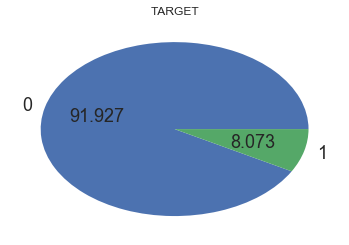

In [5]:
_ = train.TARGET.value_counts().plot(kind="pie", title="TARGET", autopct='%.3f', fontsize=18).set(ylabel="")

<a id="train_num"></a>

## [^](#toc) <u>Numeric columns</u>

### Flag Documents

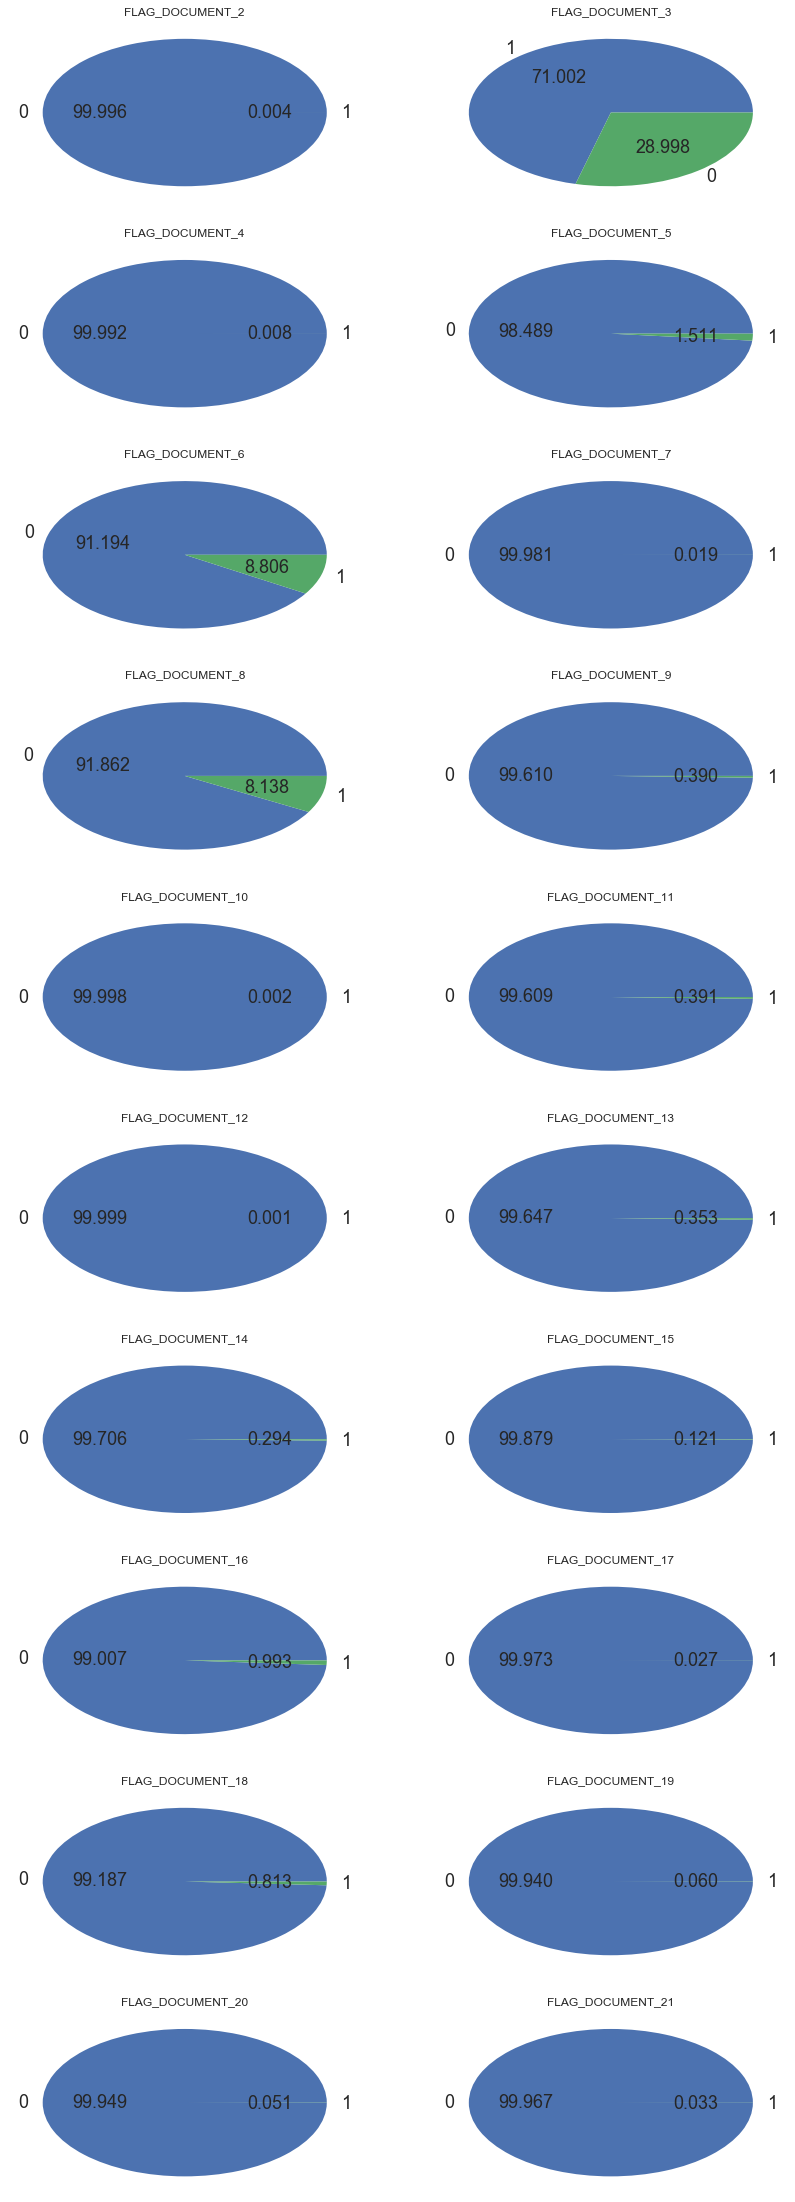

In [11]:
fig, axarr = plt.subplots(10, 2, figsize=(14, 40))

cols = [
        'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
        'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
        'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
        'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
        'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
        'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
        'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'
]

for i, col in enumerate(cols):
    (train[col]
         .value_counts()
         .plot(kind="pie", autopct='%.3f', fontsize=18, ax=axarr[i//2][i%2])
         .set(title=col, ylabel=""))

### Days birth

[Text(0.5,1,'Age in years')]

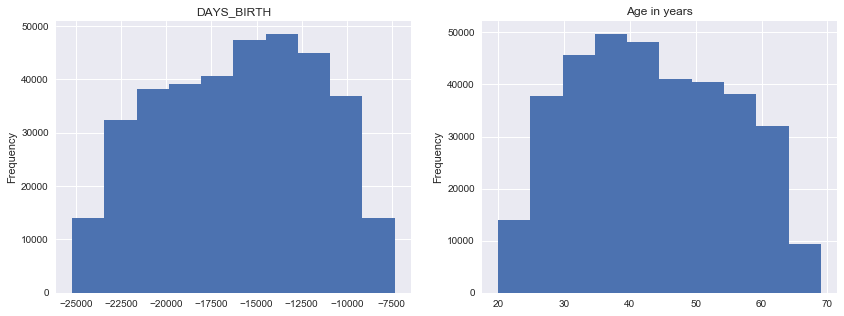

In [15]:
fig, axarr = plt.subplots(1, 2, figsize=(14, 5))

full.DAYS_BIRTH.plot(kind="hist", ax=axarr[0]).set(title="DAYS_BIRTH")
full.DAYS_BIRTH.map(lambda x: -int(x / 365)).plot(kind="hist", ax=axarr[1]).set(title="Age in years");

<a id="train_cat"></a>

### [^](#toc) <u>Categorical columns</u>

#### Plots of each of the categorical features

Thankfully they all seem to have a limited number of entries so either factorization or dummies is possible.  OCCUPATION_TYPE seems to have the most variety, but it's still doable

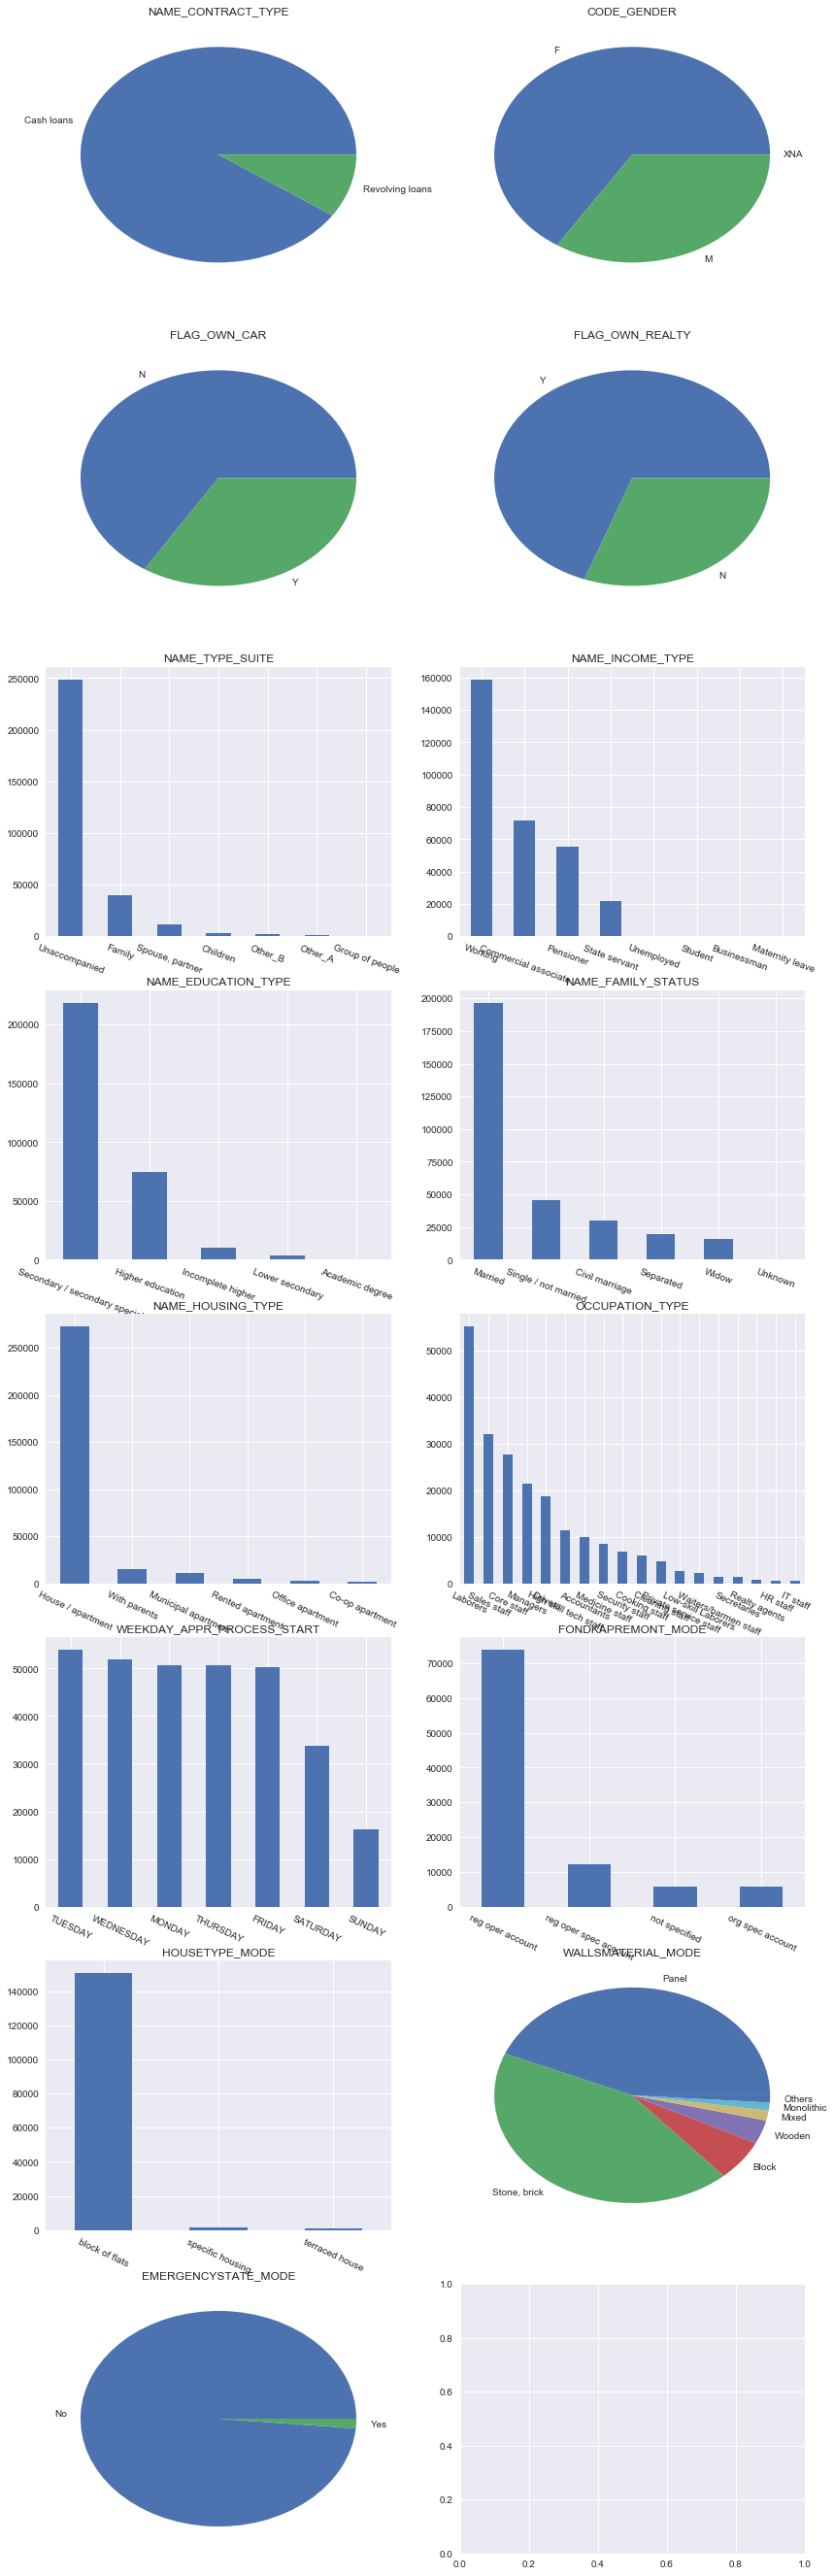

In [61]:
fig, axarr = plt.subplots(8, 2, figsize=(14, 48))

train.NAME_CONTRACT_TYPE.value_counts().plot(kind="pie", title="NAME_CONTRACT_TYPE", ax=axarr[0][0]).set(ylabel="")
train.CODE_GENDER.value_counts().plot(kind="pie", title="CODE_GENDER", ax=axarr[0][1]).set(ylabel="")
train.FLAG_OWN_CAR.value_counts().plot(kind="pie", title="FLAG_OWN_CAR", ax=axarr[1][0]).set(ylabel="")
train.FLAG_OWN_REALTY.value_counts().plot(kind="pie", title="FLAG_OWN_REALTY", ax=axarr[1][1]).set(ylabel="")

train.NAME_TYPE_SUITE.value_counts().plot(kind="bar", title="NAME_TYPE_SUITE", rot=-20, ax=axarr[2][0])
train.NAME_INCOME_TYPE.value_counts().plot(kind="bar", title="NAME_INCOME_TYPE", rot=-20, ax=axarr[2][1])
train.NAME_EDUCATION_TYPE.value_counts().plot(kind="bar", title="NAME_EDUCATION_TYPE", rot=-20, ax=axarr[3][0])
train.NAME_FAMILY_STATUS.value_counts().plot(kind="bar", title="NAME_FAMILY_STATUS", rot=-20, ax=axarr[3][1])

train.NAME_HOUSING_TYPE.value_counts().plot(kind="bar", title="NAME_HOUSING_TYPE", rot=-25, ax=axarr[4][0])
train.OCCUPATION_TYPE.value_counts().plot(kind="bar", title="OCCUPATION_TYPE", rot=-25, ax=axarr[4][1])
train.WEEKDAY_APPR_PROCESS_START.value_counts().plot(kind="bar", title="WEEKDAY_APPR_PROCESS_START", rot=-25, ax=axarr[5][0])
train.FONDKAPREMONT_MODE.value_counts().plot(kind="bar", title="FONDKAPREMONT_MODE", rot=-25, ax=axarr[5][1])

train.HOUSETYPE_MODE.value_counts().plot(kind="bar", title="HOUSETYPE_MODE", rot=-25, ax=axarr[6][0])
train.WALLSMATERIAL_MODE.value_counts().plot(kind="pie", title="WALLSMATERIAL_MODE", ax=axarr[6][1]).set(ylabel="")
_ = train.EMERGENCYSTATE_MODE.value_counts().plot(kind="pie", title="EMERGENCYSTATE_MODE", ax=axarr[7][0]).set(ylabel="")

<a id="train_skew"></a>

### [^](#toc) Skew

In [6]:
num_cols = [col for col in train.columns if (train[col].dtype != object and "nan" not in col)]

# Check the skew of all numerical features
skewed_feats = train[num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew' :skewed_feats})
skewed_features = skewness[abs(skewness) > 0.75].index
print(len(skewed_features))
print(skewed_features)
skewness

106
Index(['FLAG_DOCUMENT_12', 'AMT_INCOME_TOTAL', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_2', 'AMT_REQ_CREDIT_BUREAU_QRT', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_21',
       'FLAG_DOCUMENT_20',
       ...
       'FLAG_DOCUMENT_3', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI',
       'YEARS_BUILD_MODE', 'FLAG_EMP_PHONE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI',
       'FLAG_CONT_MOBILE', 'FLAG_MOBIL'],
      dtype='object', length=106)


,Skew
FLAG_DOCUMENT_12,392.112866
AMT_INCOME_TOTAL,391.557744
FLAG_DOCUMENT_10,209.588031
FLAG_DOCUMENT_2,153.791067
AMT_REQ_CREDIT_BUREAU_QRT,134.365018
FLAG_DOCUMENT_4,110.893823
FLAG_DOCUMENT_7,72.173756
FLAG_DOCUMENT_17,61.213842
FLAG_DOCUMENT_21,54.612673
FLAG_DOCUMENT_20,44.364680


---
<a name="bureau"></a>

# [^](#toc) <u>bureau.csv</u>

(Open to see description of columns)

<div hidden>

,Row,Description,Special

125,SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau ",hashed
126,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application),hashed
127,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,
128,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit,recoded

129,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit,time only relative to the application
130,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample,
131,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit,time only relative to the application
132,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit),time only relative to the application
133,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample),
134,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged,

135,AMT_CREDIT_SUM,Current credit amount for the Credit Bureau credit,
136,AMT_CREDIT_SUM_DEBT,Current debt on Credit Bureau credit,
137,AMT_CREDIT_SUM_LIMIT,Current credit limit of credit card reported in Credit Bureau,
138,AMT_CREDIT_SUM_OVERDUE,Current amount overdue on Credit Bureau credit,

139,CREDIT_TYPE,"Type of Credit Bureau credit (Car, cash,...)",
140,DAYS_CREDIT_UPDATE,How many days before loan application did last information about the Credit Bureau credit come,time only relative to the application
141,AMT_ANNUITY,Annuity of the Credit Bureau credit,

</div>

In [5]:
bureau = load("bureau.csv")
print("\nShape of bureau:",  bureau.shape)

print("\n{}Columns of bureau:{}".format(color.UNDERLINE, color.END))
print(" --- ".join(bureau.columns.values))

Shape of bureau: (1716428, 17)

Columns of bureau:
SK_ID_CURR --- SK_ID_BUREAU --- CREDIT_ACTIVE --- CREDIT_CURRENCY --- DAYS_CREDIT --- CREDIT_DAY_OVERDUE --- DAYS_CREDIT_ENDDATE --- DAYS_ENDDATE_FACT --- AMT_CREDIT_MAX_OVERDUE --- CNT_CREDIT_PROLONG --- AMT_CREDIT_SUM --- AMT_CREDIT_SUM_DEBT --- AMT_CREDIT_SUM_LIMIT --- AMT_CREDIT_SUM_OVERDUE --- CREDIT_TYPE --- DAYS_CREDIT_UPDATE --- AMT_ANNUITY


### Numeric and Categoric columns

In [4]:
num_cols = [col for col in bureau.columns if bureau[col].dtype != object]
cat_cols = [col for col in bureau.columns if bureau[col].dtype == object]

print("\n{}Numeric columns:{}".format(color.UNDERLINE, color.END))
print(" --- ".join(num_cols))

print("\n{}Categoric columns:{}".format(color.UNDERLINE, color.END))
print(" --- ".join(cat_cols))


Numeric columns:
SK_ID_CURR --- SK_ID_BUREAU --- DAYS_CREDIT --- CREDIT_DAY_OVERDUE --- DAYS_CREDIT_ENDDATE --- DAYS_ENDDATE_FACT --- AMT_CREDIT_MAX_OVERDUE --- CNT_CREDIT_PROLONG --- AMT_CREDIT_SUM --- AMT_CREDIT_SUM_DEBT --- AMT_CREDIT_SUM_LIMIT --- AMT_CREDIT_SUM_OVERDUE --- DAYS_CREDIT_UPDATE --- AMT_ANNUITY

Categoric columns:
CREDIT_ACTIVE --- CREDIT_CURRENCY --- CREDIT_TYPE


### Missing values

In [6]:
num_missing = bureau.isnull().sum()
num_total = len(bureau)

pd.DataFrame({
    "Total missing": num_missing,
    "Percent missing": num_missing / num_total
})

,Percent missing,Total missing
SK_ID_CURR,0.000000,0
SK_ID_BUREAU,0.000000,0
CREDIT_ACTIVE,0.000000,0
CREDIT_CURRENCY,0.000000,0
DAYS_CREDIT,0.000000,0
CREDIT_DAY_OVERDUE,0.000000,0
DAYS_CREDIT_ENDDATE,0.061496,105553
DAYS_ENDDATE_FACT,0.369170,633653
AMT_CREDIT_MAX_OVERDUE,0.655133,1124488
CNT_CREDIT_PROLONG,0.000000,0


#### Look closer

All the missing values are numeric.  And they all have a big mode at 0

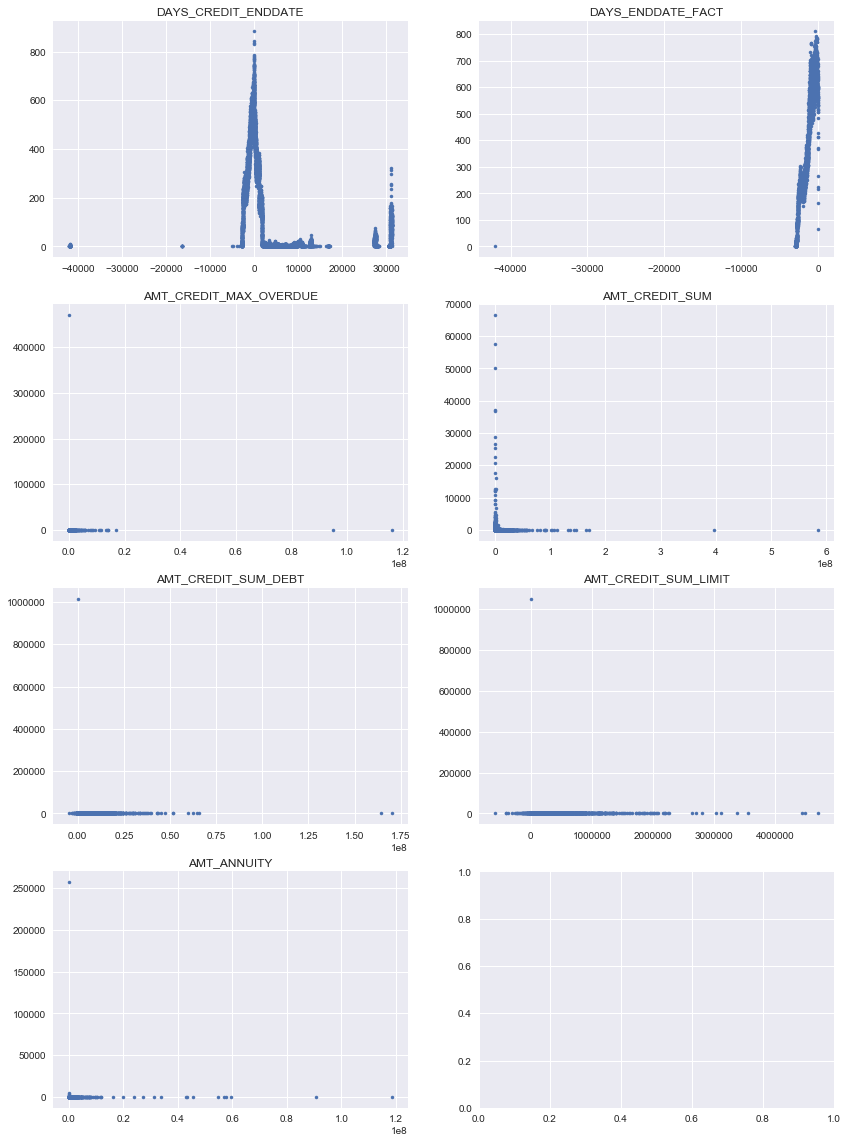

In [10]:
fig, axarr = plt.subplots(4, 2, figsize=(14, 20))

cols = ["DAYS_CREDIT_ENDDATE", "DAYS_ENDDATE_FACT", "AMT_CREDIT_MAX_OVERDUE",
        "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT",
        "AMT_ANNUITY"]

for i, col in enumerate(cols):
    ax = axarr[i//2][i%2]
    temp = bureau[col].value_counts()
    ax.plot(temp, ".")
    ax.set_title(col)
    

#### Missing values - Treatment

Fill in NaN values with the mode and mark as being filled in

In [29]:
for col in tqdm(cols):
    bureau[col + "_nan"] = bureau[col].map(lambda x: 1 if np.isnan(x) else 0)
    mode                 = bureau[bureau[col].notnull()][col].mode().iloc[0]
    bureau[col]          = bureau[col].fillna(mode)
    
sum(bureau.isnull().sum())

100%|██████████| 7/7 [00:20<00:00,  2.91s/it]


0

### Categorical data

CREDIT_ACTIVE --- CREDIT_CURRENCY --- CREDIT_TYPE

#### CREDIT_ACTIVE

In [ ]:
bureau.CREDIT_ACTIVE.value_counts()

#### CREDIT_CURRENCY

In [6]:
bureau.CREDIT_CURRENCY.value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

#### CREDIT_TYPE

In [7]:
bureau.CREDIT_TYPE.value_counts()

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: CREDIT_TYPE, dtype: int64

---
<a name="bureau_balance"></a>

# [^](#toc) <u>bureau_balance.csv</u>

(Open to see description of columns)

<div hidden>

,Row,Description,Special

142,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table ,hashed
143,MONTHS_BALANCE,Month of balance relative to application date (-1 means the freshest balance date),time only relative to the application
144,STATUS,"Status of Credit Bureau loan during the month (active, closed, DPD0-30,Ö [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,Ö 5 means DPD 120+ or sold or written off ] )",

</div>

In [63]:
bureau_balance = load("bureau_balance.csv")
print("Shape of bureau_balance:",  bureau_balance.shape)

print("\n{}Columns of bureau_balance:{}".format(color.UNDERLINE, color.END))
print(" --- ".join(bureau_balance.columns.values))

Shape of bureau_balance: (27299925, 3)

Columns of bureau_balance:
SK_ID_BUREAU --- MONTHS_BALANCE --- STATUS


<a id="bur_bal_month"></a>

### [^](#toc) MONTHS_BALANCE

FIXME: I wonder if this should be added like (1/abs(months)) * status.  Sum each of the status this way.  Less weight will be put on older times

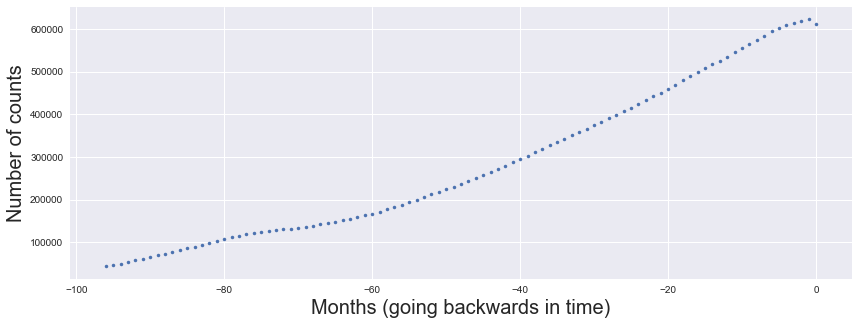

In [64]:
plt.figure(figsize=(14, 5))

temp = bureau_balance.MONTHS_BALANCE.value_counts()
plt.plot(temp, ".")

plt.ylabel("Number of counts", fontsize=20)
_ = plt.xlabel("Months (going backwards in time)", fontsize=20)

<a id="bur_bal_stat"></a>

### [^](#toc) STATUS

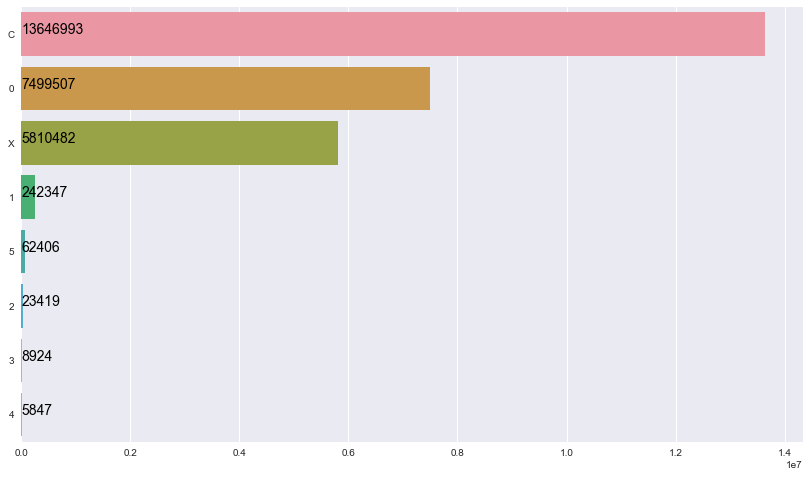

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
temp = bureau_balance.STATUS.value_counts()
pretty_bar(temp, ax)

<a name="prev_app"></a>

# [^](#toc) <u>previous_application.csv</u>

(Open to see description of columns)

<div hidden>

,Row,Description,Special

176,SK_ID_PREV ,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit) ",hashed
177,SK_ID_CURR,ID of loan in our sample,hashed

178,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application",
179,AMT_ANNUITY,Annuity of previous application,

180,AMT_APPLICATION,For how much credit did client ask on the previous application,
181,AMT_CREDIT,"Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT",

182,AMT_DOWN_PAYMENT,Down payment on the previous application,
183,AMT_GOODS_PRICE,Goods price of good that client asked for (if applicable) on the previous application,
184,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for previous application,
185,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client apply for the previous application,rounded
186,FLAG_LAST_APPL_PER_CONTRACT,Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract,
187,NFLAG_LAST_APPL_IN_DAY,Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be error in our system that one application is in the database twice,
188,NFLAG_MICRO_CASH,Flag Micro finance loan,
189,RATE_DOWN_PAYMENT,Down payment rate normalized on previous credit,normalized
190,RATE_INTEREST_PRIMARY,Interest rate normalized on previous credit,normalized
191,RATE_INTEREST_PRIVILEGED,Interest rate normalized on previous credit,normalized
192,NAME_CASH_LOAN_PURPOSE,Purpose of the cash loan,
193,NAME_CONTRACT_STATUS,"Contract status (approved, cancelled, ...) of previous application",

194,DAYS_DECISION,Relative to current application when was the decision about previous application made,time only relative to the application

195,NAME_PAYMENT_TYPE,Payment method that client chose to pay for the previous application,
196,CODE_REJECT_REASON,Why was the previous application rejected,
197,NAME_TYPE_SUITE,Who accompanied client when applying for the previous application,

198,NAME_CLIENT_TYPE,Was the client old or new client when applying for the previous application,

199,NAME_GOODS_CATEGORY,What kind of goods did the client apply for in the previous application,
200,NAME_PORTFOLIO,"Was the previous application for CASH, POS, CAR, Ö",
201,NAME_PRODUCT_TYPE,Was the previous application x-sell o walk-in,
202,CHANNEL_TYPE,Through which channel we acquired the client on the previous application,
203,SELLERPLACE_AREA,Selling area of seller place of the previous application,
204,NAME_SELLER_INDUSTRY,The industry of the seller,
205,CNT_PAYMENT,Term of previous credit at application of the previous application,
206,NAME_YIELD_GROUP,Grouped interest rate into small medium and high of the previous application,grouped
207,PRODUCT_COMBINATION,Detailed product combination of the previous application,

208,DAYS_FIRST_DRAWING,Relative to application date of current application when was the first disbursement of the previous application,time only relative to the application
209,DAYS_FIRST_DUE,Relative to application date of current application when was the first due supposed to be of the previous application,time only relative to the application
210,DAYS_LAST_DUE_1ST_VERSION,Relative to application date of current application when was the first due of the previous application,time only relative to the application
211,DAYS_LAST_DUE,Relative to application date of current application when was the last due date of the previous application,time only relative to the application
212,DAYS_TERMINATION,Relative to application date of current application when was the expected termination of the previous application,time only relative to the application

213,NFLAG_INSURED_ON_APPROVAL,Did the client requested insurance during the previous application,

</div>

In [10]:
prev_app = load("previous_application.csv")
print("Shape of prev_app:",  prev_app.shape)

print("\n{}Columns of prev_app:{}".format(color.UNDERLINE, color.END))
print(" --- ".join(prev_app.columns.values))

Shape of prev_app: (1670214, 37)

Columns of prev_app:
SK_ID_PREV --- SK_ID_CURR --- NAME_CONTRACT_TYPE --- AMT_ANNUITY --- AMT_APPLICATION --- AMT_CREDIT --- AMT_DOWN_PAYMENT --- AMT_GOODS_PRICE --- WEEKDAY_APPR_PROCESS_START --- HOUR_APPR_PROCESS_START --- FLAG_LAST_APPL_PER_CONTRACT --- NFLAG_LAST_APPL_IN_DAY --- RATE_DOWN_PAYMENT --- RATE_INTEREST_PRIMARY --- RATE_INTEREST_PRIVILEGED --- NAME_CASH_LOAN_PURPOSE --- NAME_CONTRACT_STATUS --- DAYS_DECISION --- NAME_PAYMENT_TYPE --- CODE_REJECT_REASON --- NAME_TYPE_SUITE --- NAME_CLIENT_TYPE --- NAME_GOODS_CATEGORY --- NAME_PORTFOLIO --- NAME_PRODUCT_TYPE --- CHANNEL_TYPE --- SELLERPLACE_AREA --- NAME_SELLER_INDUSTRY --- CNT_PAYMENT --- NAME_YIELD_GROUP --- PRODUCT_COMBINATION --- DAYS_FIRST_DRAWING --- DAYS_FIRST_DUE --- DAYS_LAST_DUE_1ST_VERSION --- DAYS_LAST_DUE --- DAYS_TERMINATION --- NFLAG_INSURED_ON_APPROVAL


max(AMT_APPLICATION - AMT_CREDIT)

min(AMT_APPLICATION - AMT_CREDIT)

In [13]:
prev_app.groupby("SK_ID_CURR").count()

,SK_ID_PREV,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
100002,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
100003,3,3,3,3,3,2,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
100004,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
100005,2,2,1,2,2,1,1,2,2,2,...,2,1,2,2,1,1,1,1,1,1
100006,9,9,6,9,9,2,6,9,9,9,...,9,6,9,9,4,4,4,4,4,4
100007,6,6,6,6,6,2,6,6,6,6,...,6,6,6,6,5,5,5,5,5,5
100008,5,5,4,5,5,3,4,5,5,5,...,5,4,5,5,4,4,4,4,4,4
100009,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7


### CODE_REJECT_REASON

In [12]:
prev_app.CODE_REJECT_REASON.value_counts()

XAP       1353093
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: CODE_REJECT_REASON, dtype: int64

### NAME_CLIENT_TYPE

Does this contain any information?  I think this is covered already in the number of applications

In [11]:
prev_app.NAME_CLIENT_TYPE.value_counts()

Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: NAME_CLIENT_TYPE, dtype: int64

### Correlation plot

Just for fun!

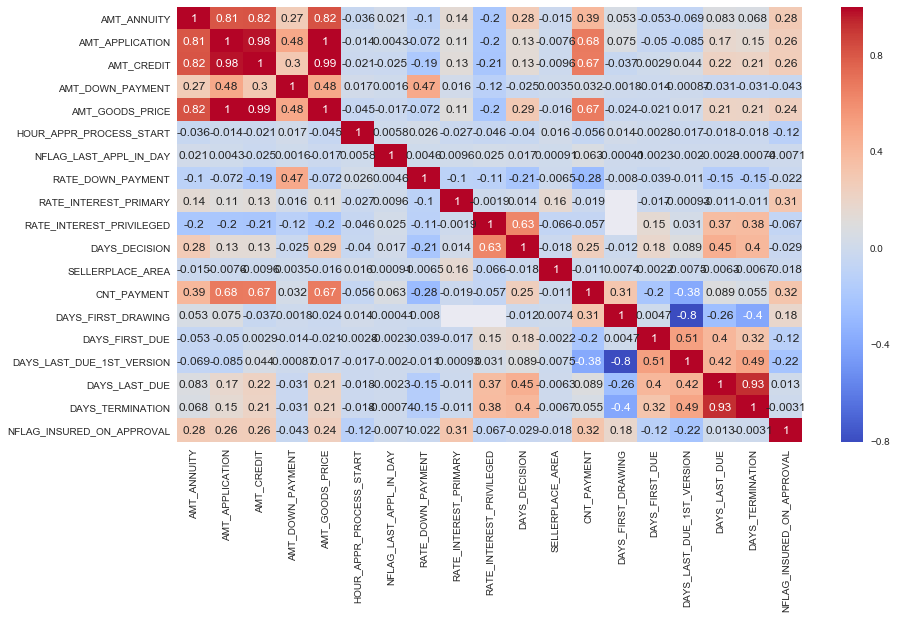

In [225]:
plt.figure(figsize=(14, 8))
f = prev_app.drop(["SK_ID_PREV", "SK_ID_CURR"], axis=1).corr()
_ = sns.heatmap(f, annot=True, cmap="coolwarm")

<a id="prev_nan"></a>

### [^](#toc) <u>Missing values</u>

In [13]:
prev_app.isnull().sum()

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

<a id="prev_cat_plots"></a>

### [^](#toc) <u>Categorical columns</u>

The only categorical columns missing values are 'NAME_TYPE_SUITE' (missing <strong>820405</strong> values) and 'PRODUCT_COMBINATION' (missing <strong>346</strong> values).

In [121]:
cat_cols = [col for col in prev_app if prev_app[col].dtype==object]
cat_cols

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

### Missing values - categorical

Nothing fancy, just marking the values as missing.  A potential future step would be to put the mean, mode, groupby then median, something along those lines

In [14]:
for col in ("NAME_TYPE_SUITE", "PRODUCT_COMBINATION"):
    prev_app[col] = prev_app[col].fillna("NaN")

<a id="prev_cat_plots"></a>

### [^](#toc) <u>Categorical plots</u>

Does not include NAME_CASH_LOAN_PURPOSE, NAME_GOODS_CATEGORY, PRODUCT_COMBINATION, NAME_SELLER_INDUSTRY

They have too many different values so I'll treat them separately.

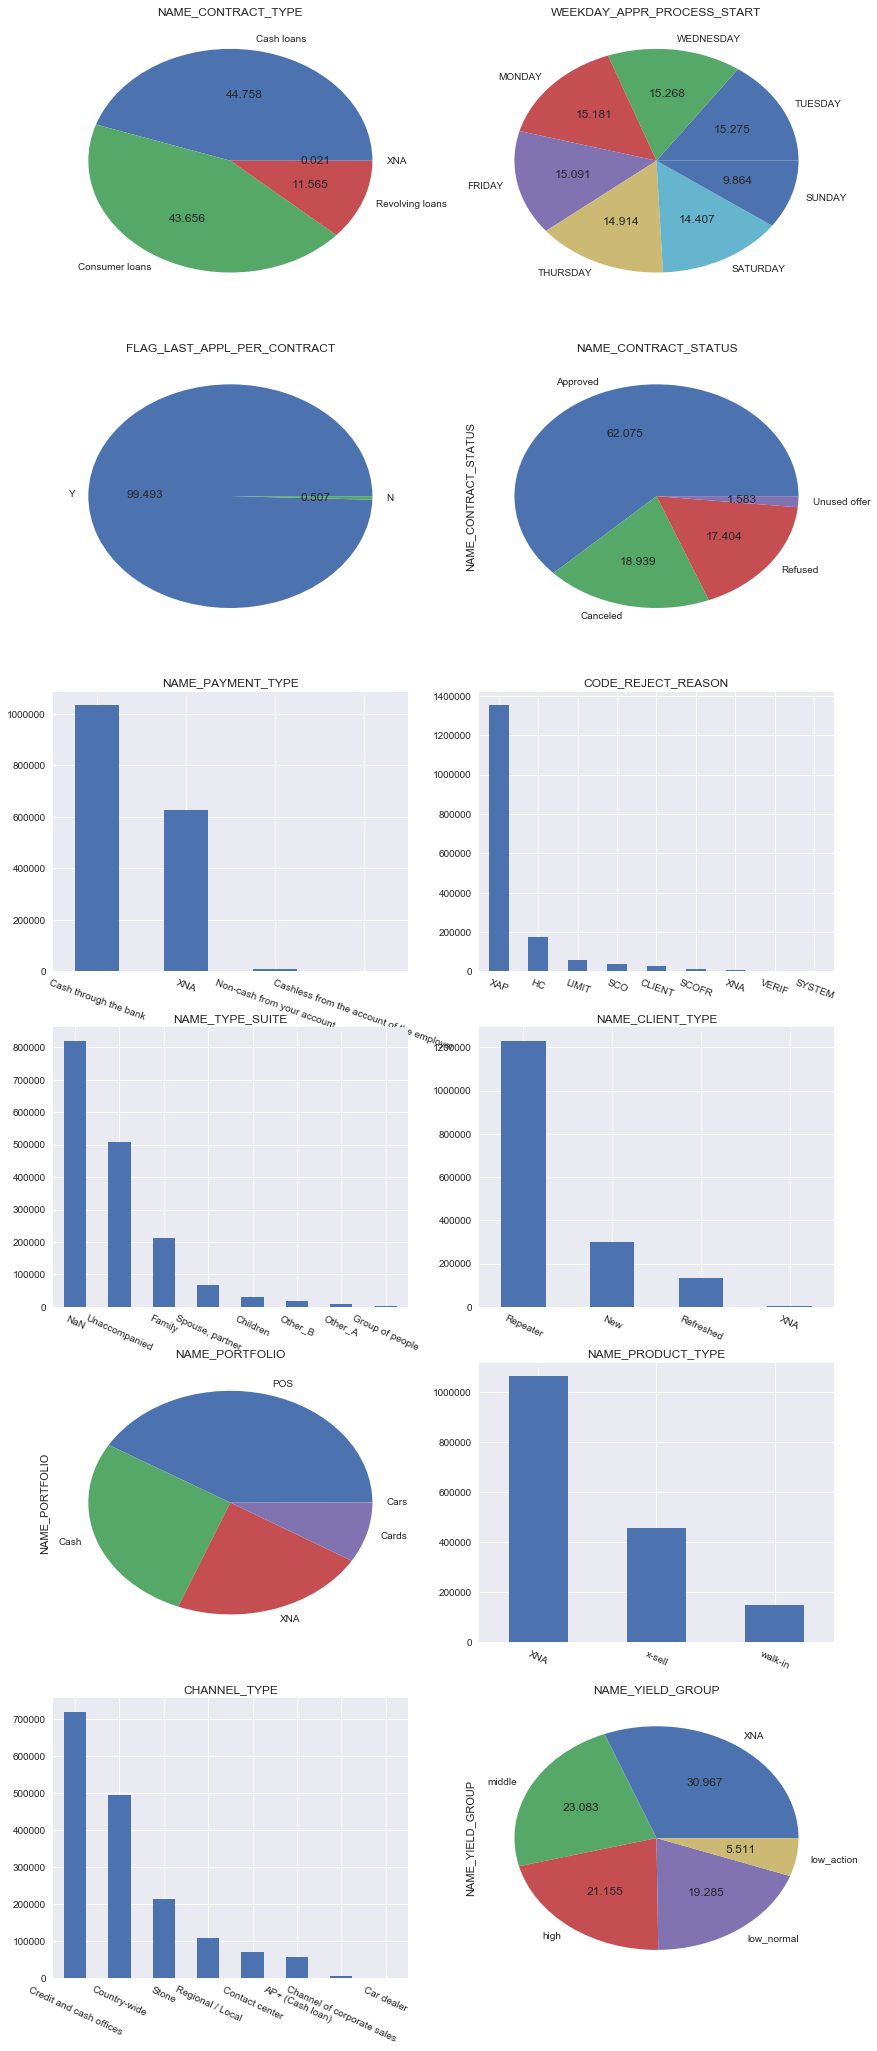

In [92]:
fig, axarr = plt.subplots(6, 2, figsize=(14, 36))

(prev_app.NAME_CONTRACT_TYPE.value_counts()
    .plot(kind="pie", title="NAME_CONTRACT_TYPE", autopct='%.3f', ax=axarr[0][0]).set(ylabel=""))
(prev_app.WEEKDAY_APPR_PROCESS_START.value_counts()
    .plot(kind="pie", title="WEEKDAY_APPR_PROCESS_START", autopct='%.3f', ax=axarr[0][1]).set(ylabel=""))
(prev_app.FLAG_LAST_APPL_PER_CONTRACT.value_counts()
    .plot(kind="pie", title="FLAG_LAST_APPL_PER_CONTRACT", autopct='%.3f', ax=axarr[1][0]).set(ylabel=""))
(prev_app.NAME_CONTRACT_STATUS.value_counts()
    .plot(kind="pie", title="NAME_CONTRACT_STATUS", autopct='%.3f', ax=axarr[1][1]))

(prev_app.NAME_PAYMENT_TYPE.value_counts()
    .plot(kind="bar", title="NAME_PAYMENT_TYPE", rot=-20, ax=axarr[2][0]))
(prev_app.CODE_REJECT_REASON.value_counts()
    .plot(kind="bar", title="CODE_REJECT_REASON", rot=-20, ax=axarr[2][1]))
(prev_app.NAME_TYPE_SUITE.value_counts()
    .plot(kind="bar", title="NAME_TYPE_SUITE", rot=-25, ax=axarr[3][0]))
(prev_app.NAME_CLIENT_TYPE.value_counts()
    .plot(kind="bar", title="NAME_CLIENT_TYPE", rot=-25, ax=axarr[3][1]))

(prev_app.NAME_PORTFOLIO.value_counts()
    .plot(kind="pie", title="NAME_PORTFOLIO", rot=-25, ax=axarr[4][0]))
(prev_app.NAME_PRODUCT_TYPE.value_counts()
    .plot(kind="bar", title="NAME_PRODUCT_TYPE", rot=-25, ax=axarr[4][1]))
(prev_app.CHANNEL_TYPE.value_counts()
    .plot(kind="bar", title="CHANNEL_TYPE", rot=-25, ax=axarr[5][0]))
_ = (prev_app.NAME_YIELD_GROUP.value_counts()
    .plot(kind="pie", title="NAME_YIELD_GROUP",  autopct='%.3f', ax=axarr[5][1]))

<a id="prev_remain_cat"></a>

### [^](#toc) <u>Remaining categorical columns</u>

<a id="prev_name_cash_loan_purpose"></a>

### [^](#toc) <u>NAME_CASH_LOAN_PURPOSE</u>

'Hobby', 'Money for a third person', and 'Refusal to name the goal' should probably all be combined into 'other'

In [4]:
prev_app.NAME_CASH_LOAN_PURPOSE.value_counts()

XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15608
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                              2174
Payments on other loans               1931
Education                             1573
Journey                               1239
Purchase of electronic equipment      1061
Buying a new car                      1012
Wedding / gift / holiday               962
Buying a home                          865
Car repairs                            797
Furniture                              749
Buying a holiday home / land           533
Business development                   426
Gasification / water supply            300
Buying a garage                        136
Hobby                                   55
Money for a

<a id="prev_name_goods_cat"></a>

### [^](#toc) <u>NAME_GOODS_CATEGORY</u>

The rows containing 'House Contruction' and 'Animals' should probably be dropped since they have only one instance.

In [77]:
prev_app.NAME_GOODS_CATEGORY.value_counts()

XNA                         950809
Mobile                      224708
Consumer Electronics        121576
Computers                   105769
Audio/Video                  99441
Furniture                    53656
Photo / Cinema Equipment     25021
Construction Materials       24995
Clothing and Accessories     23554
Auto Accessories              7381
Jewelry                       6290
Homewares                     5023
Medical Supplies              3843
Vehicles                      3370
Sport and Leisure             2981
Gardening                     2668
Other                         2554
Office Appliances             2333
Tourism                       1659
Medicine                      1550
Direct Sales                   446
Fitness                        209
Additional Service             128
Education                      107
Weapon                          77
Insurance                       64
House Construction               1
Animals                          1
Name: NAME_GOODS_CAT

<a id="prev_prod_combin"></a>

### [^](#toc) <u>PRODUCT_COMBINATION</u>

Everything seems fine here

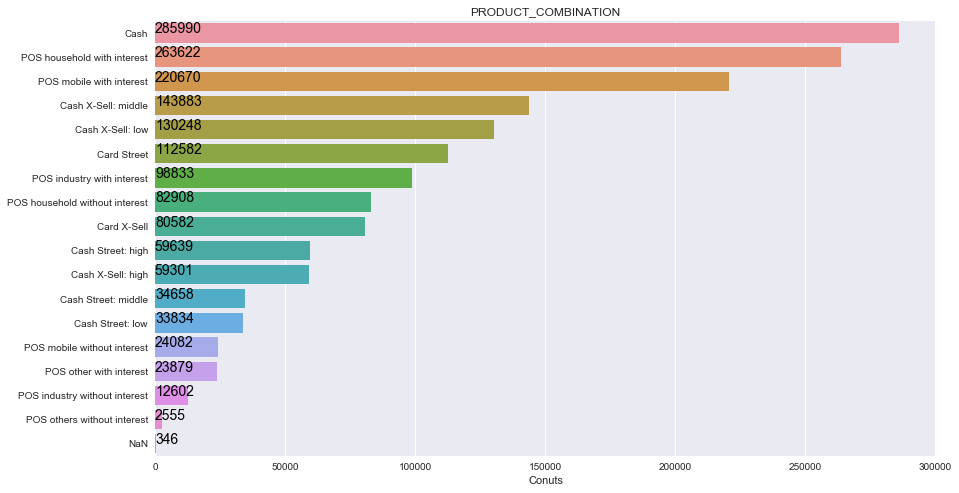

In [88]:
fig, ax = plt.subplots(1,1, figsize=(14, 8))
temp = prev_app.PRODUCT_COMBINATION.value_counts()
pretty_bar(temp, ax, title="PRODUCT_COMBINATION", xlabel="Conuts")

<a id="prev_name_sell_indus"></a>

### [^](#toc) <u>NAME_SELLER_INDUSTRY</u>

Again everything looks good

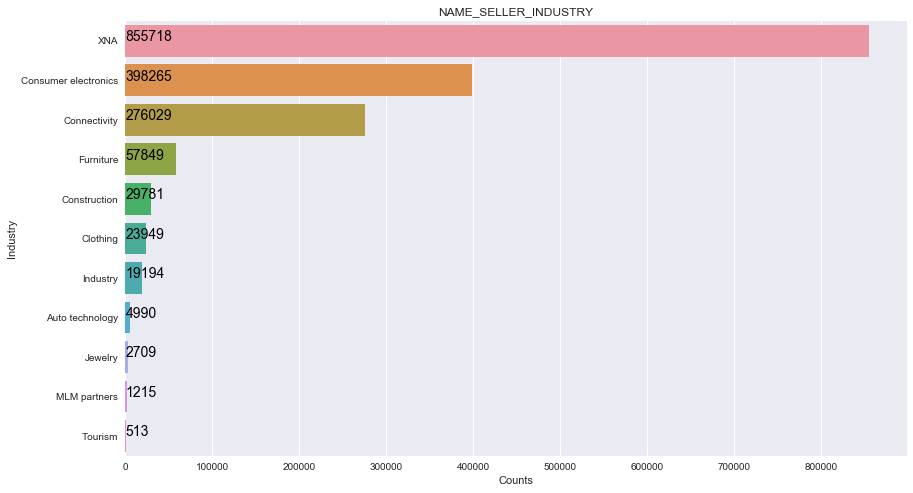

In [17]:
fig, ax = plt.subplots(1,1, figsize=(14, 8))
temp = prev_app.NAME_SELLER_INDUSTRY.value_counts()
pretty_bar(temp, ax, title="NAME_SELLER_INDUSTRY", ylabel="Industry", xlabel="Counts")

<a id="prev_num_col"></a>

### [^](#toc) <u>Numeric columns</u>

In [18]:
num_cols = [col for col in prev_app if prev_app[col].dtype!=object and col not in ["SK_ID_PREV", "SK_ID_CURR"]]
num_cols

['AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

<a id="prev_num_nan"></a>

### [^](#toc) <u>Missing Values - Numeric</u>

Let's treat this in groups...

Low missing values:
- AMT_CREDIT

Moderate missing values:
- AMT_ANNUITY, AMT_GOODS_PRICE, CNT_PAYMENT, AMT_DOWN_PAYMENT, RATE_DOWN_PAYMENT, DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, DAYS_TERMINATION, NFLAG_INSURED_ON_APPROVAL

Severe missing values:
- RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED


In [19]:
prev_app[num_cols].isnull().sum()

AMT_ANNUITY                   372235
AMT_APPLICATION                    0
AMT_CREDIT                         1
AMT_DOWN_PAYMENT              895844
AMT_GOODS_PRICE               385515
HOUR_APPR_PROCESS_START            0
NFLAG_LAST_APPL_IN_DAY             0
RATE_DOWN_PAYMENT             895844
RATE_INTEREST_PRIMARY        1664261
RATE_INTEREST_PRIVILEGED     1664261
DAYS_DECISION                      0
SELLERPLACE_AREA                   0
CNT_PAYMENT                   372230
DAYS_FIRST_DRAWING            673064
DAYS_FIRST_DUE                673064
DAYS_LAST_DUE_1ST_VERSION     673064
DAYS_LAST_DUE                 673064
DAYS_TERMINATION              673064
NFLAG_INSURED_ON_APPROVAL     673064
dtype: int64

<a id="prev_num_plots"></a>

### [^](#toc) <u>Numeric plots</u>

First I forgot what the numerical columns were

In [25]:
num_cols = [col for col in prev_app if prev_app[col].dtype!=object and col not in ["SK_ID_PREV", "SK_ID_CURR"]]
num_cols

['AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL',
 'AMT_ANNUITY_nan',
 'AMT_GOODS_PRICE_nan',
 'CNT_PAYMENT_nan',
 'AMT_DOWN_PAYMENT_nan',
 'RATE_DOWN_PAYMENT_nan',
 'DAYS_FIRST_DRAWING_nan',
 'DAYS_FIRST_DUE_nan',
 'DAYS_LAST_DUE_1ST_VERSION_nan',
 'DAYS_LAST_DUE_nan',
 'DAYS_TERMINATION_nan',
 'NFLAG_INSURED_ON_APPROVAL_nan']

#### Plots

Ignore all the columns marking whether a value is missing.  I'm also ignoring 'RATE_INTEREST_PRIMARY' and 'RATE_INTEREST_PRIVILEGED' because they had so many missing values

FIXME: the first two have skew

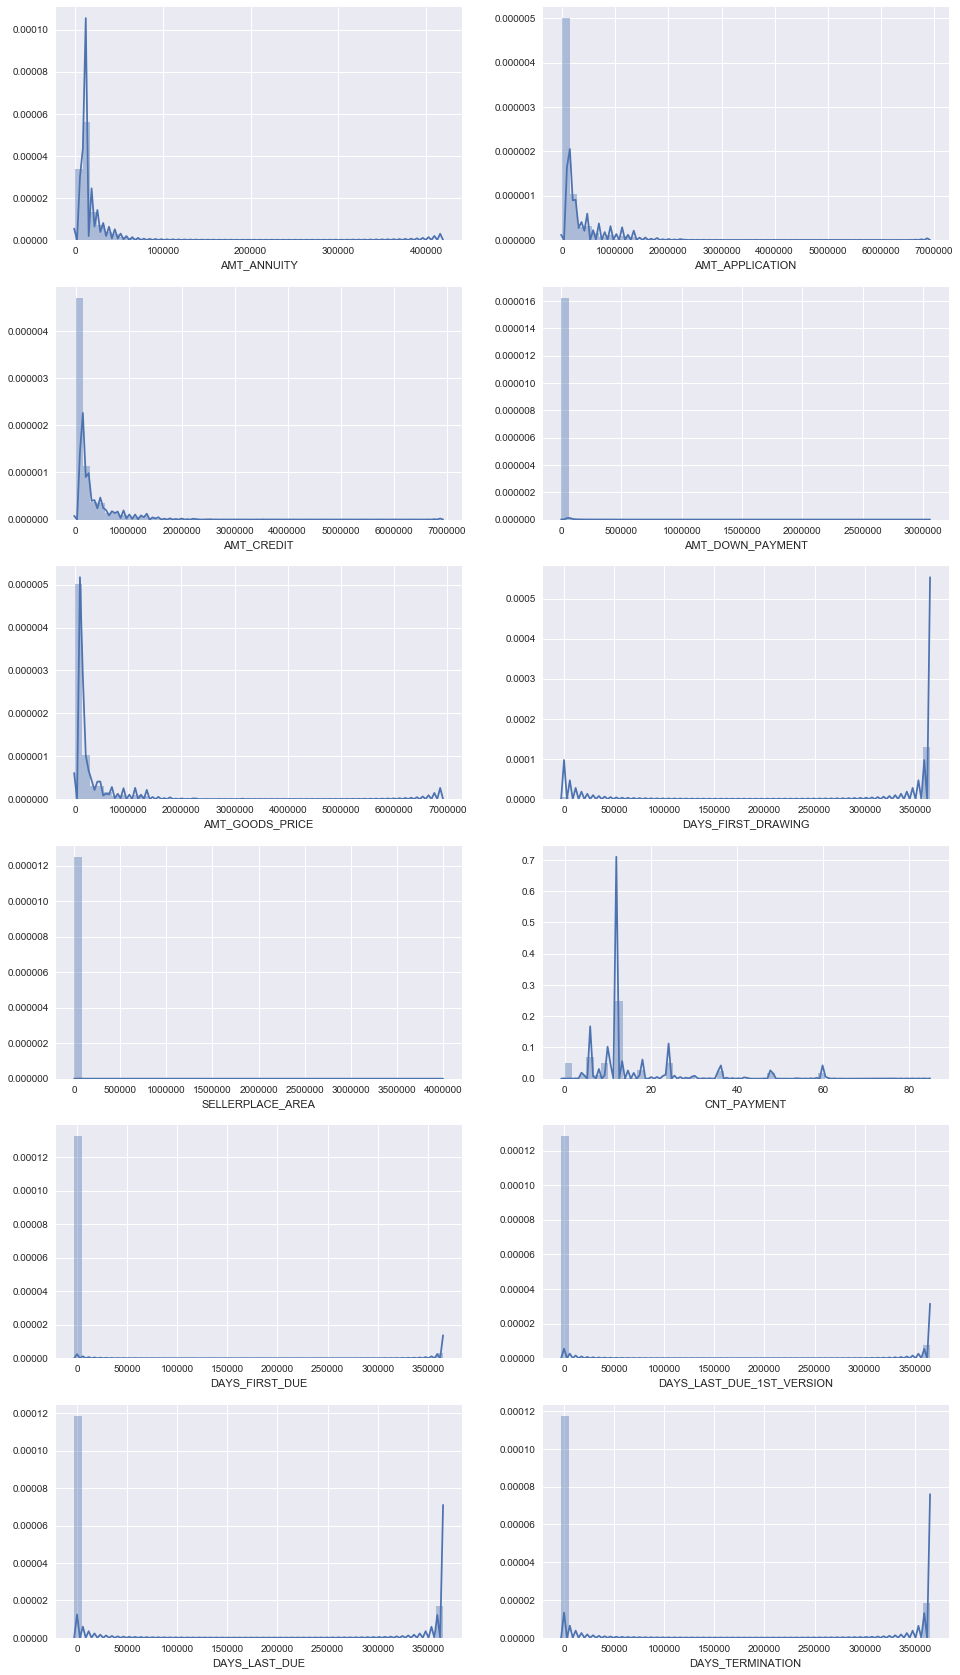

In [28]:
fig, axarr = plt.subplots(6, 2, figsize=(16, 30))

sns.distplot(prev_app['AMT_ANNUITY'], ax=axarr[0][0])
sns.distplot(prev_app['AMT_APPLICATION'], ax=axarr[0][1])
sns.distplot(prev_app['AMT_CREDIT'], ax=axarr[1][0])
sns.distplot(prev_app['AMT_DOWN_PAYMENT'], ax=axarr[1][1])

sns.distplot(prev_app['AMT_GOODS_PRICE'], ax=axarr[2][0])
sns.distplot(prev_app['DAYS_FIRST_DRAWING'], ax=axarr[2][1])
sns.distplot(prev_app['SELLERPLACE_AREA'], ax=axarr[3][0])
sns.distplot(prev_app['CNT_PAYMENT'], ax=axarr[3][1])

sns.distplot(prev_app['DAYS_FIRST_DUE'], ax=axarr[4][0])
sns.distplot(prev_app['DAYS_LAST_DUE_1ST_VERSION'], ax=axarr[4][1])
sns.distplot(prev_app['DAYS_LAST_DUE'], ax=axarr[5][0])
_ = sns.distplot(prev_app['DAYS_TERMINATION'], ax=axarr[5][1])

### DAYS_DECISION + HOUR_APPR_PROCESS_START

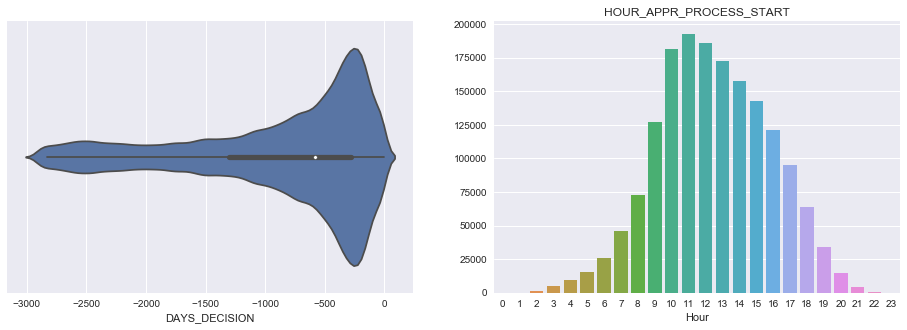

In [205]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))

sns.violinplot(prev_app["DAYS_DECISION"], title="DAYS_DECISION", ax=axarr[0])

temp = prev_app.HOUR_APPR_PROCESS_START.value_counts()
_ = sns.barplot(temp.index, temp.values, ax=axarr[1]).set(xlabel="Hour", title="HOUR_APPR_PROCESS_START")

### NFLAG_INSURED_ON_APPROVAL, NFLAG_LAST_APPL_IN_DAY, and RATE_DOWN_PAYMENT

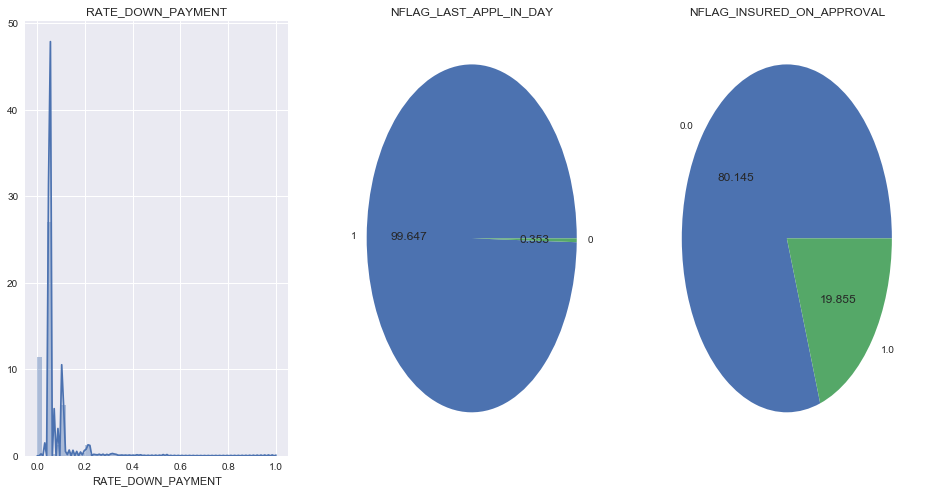

In [220]:
fig, axarr = plt.subplots(1, 3, figsize=(16, 8))

sns.distplot(prev_app["RATE_DOWN_PAYMENT"], ax=axarr[0]).set(title="RATE_DOWN_PAYMENT")

(prev_app["NFLAG_LAST_APPL_IN_DAY"].value_counts()
 .plot(kind="pie", autopct='%.3f', title="NFLAG_LAST_APPL_IN_DAY", ax=axarr[1]).set(ylabel=""))

_ = (prev_app["NFLAG_INSURED_ON_APPROVAL"].value_counts()
     .plot(kind="pie", autopct='%.3f', title="NFLAG_INSURED_ON_APPROVAL", ax=axarr[2]).set(ylabel=""))

<a id="prev_skew"></a>

### [^](#toc) Skew

In [5]:
num_cols = [col for col in prev_app.columns if (prev_app[col].dtype != object and "nan" not in col)]

# Check the skew of all numerical features
skewed_feats = prev_app[num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew' :skewed_feats})
skewed_features = skewness[abs(skewness) > 0.75].index
print(len(skewed_features))
print(skewed_features)
skewness

21
Index(['SELLERPLACE_AREA', 'AMT_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'DAYS_FIRST_DUE', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'DAYS_LAST_DUE_1ST_VERSION', 'AMT_ANNUITY', 'RATE_DOWN_PAYMENT',
       'CNT_PAYMENT', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL', 'SK_ID_PREV', 'SK_ID_CURR',
       'HOUR_APPR_PROCESS_START', 'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION',
       'DAYS_FIRST_DRAWING', 'NFLAG_LAST_APPL_IN_DAY'],
      dtype='object')


,Skew
SELLERPLACE_AREA,529.619803
AMT_DOWN_PAYMENT,36.476505
RATE_INTEREST_PRIMARY,5.196894
DAYS_FIRST_DUE,4.644089
AMT_APPLICATION,3.391439
AMT_CREDIT,3.245812
AMT_GOODS_PRICE,3.073686
DAYS_LAST_DUE_1ST_VERSION,2.779446
AMT_ANNUITY,2.692568
RATE_DOWN_PAYMENT,2.107709


### Plots of skewed features

SELLERPLACE_AREA looks like it has outliers

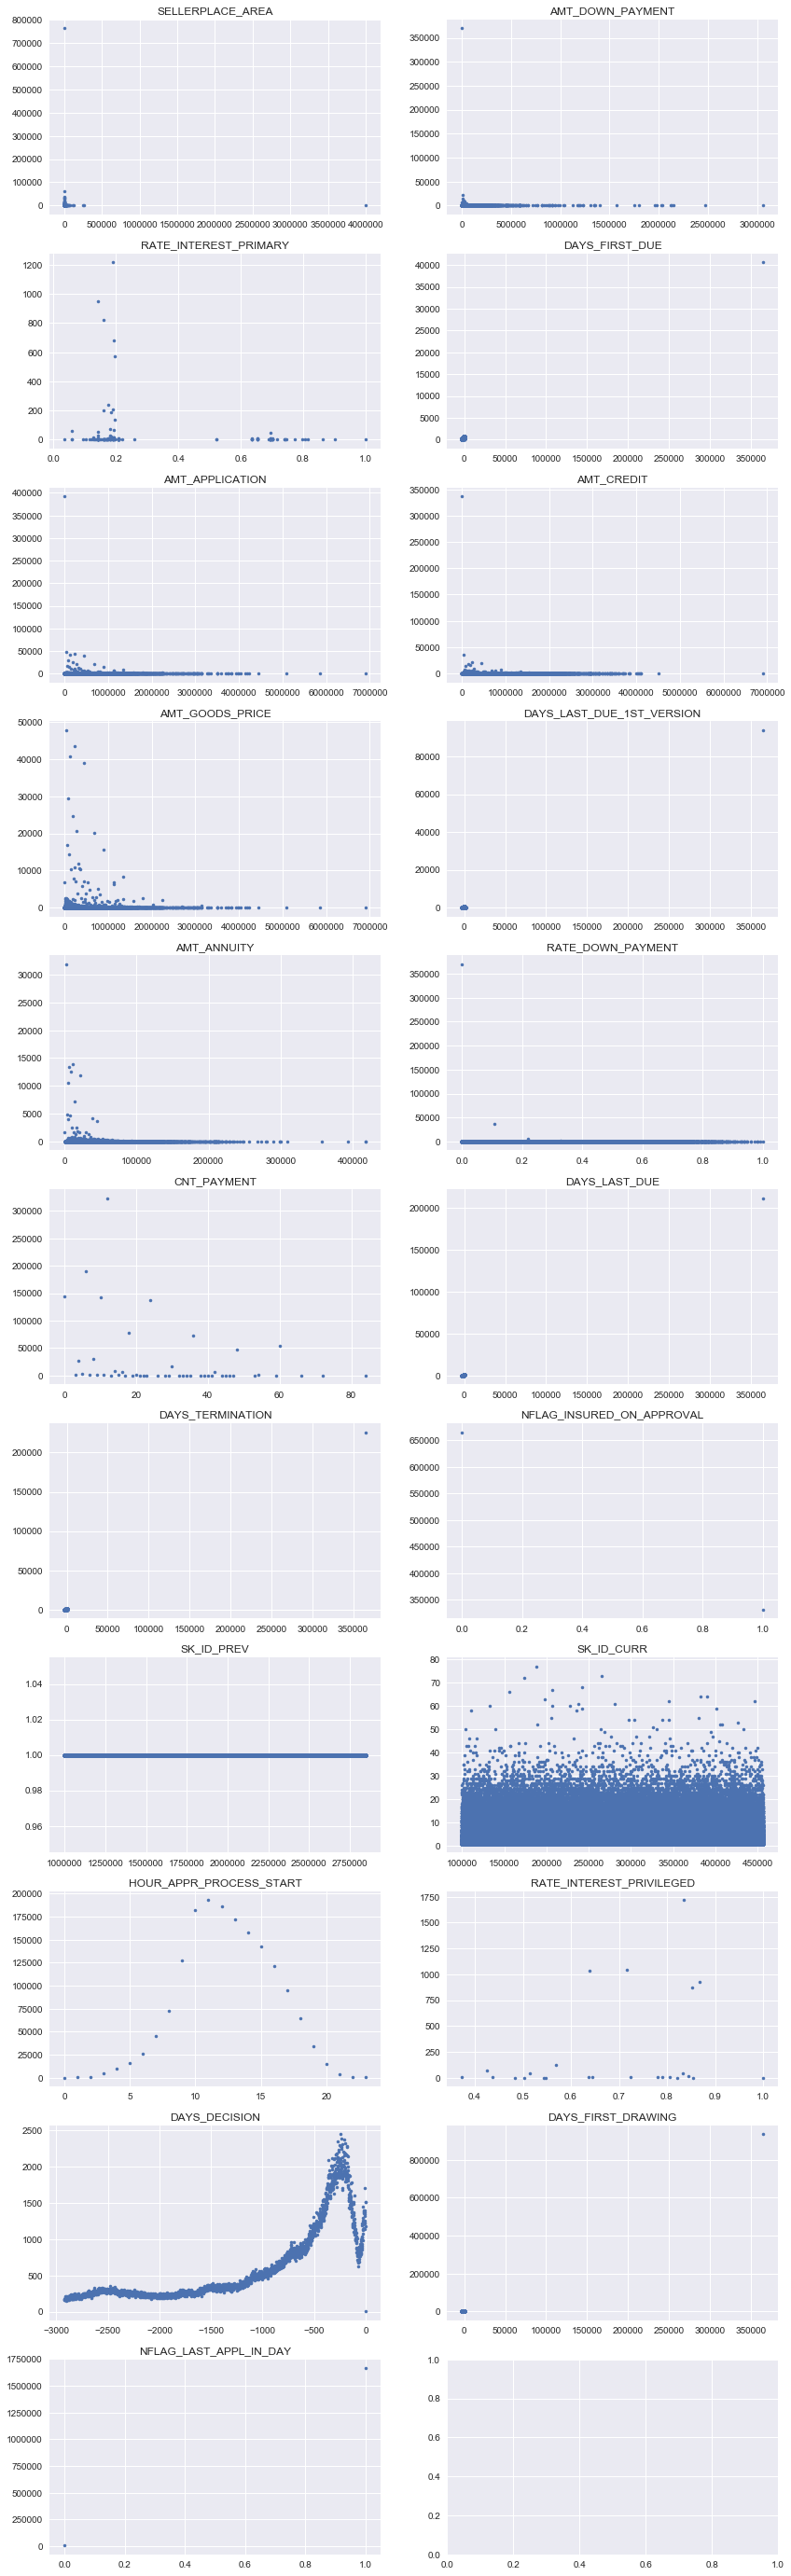

In [6]:
fig, axarr = plt.subplots(11, 2, figsize=(14, 50))

for i, col in enumerate(skewed_features):
    ax = axarr[i//2][i%2]
    temp = prev_app[col].value_counts()
    ax.plot(temp, ".")
    ax.set_title(col)

<a name="pos_cash"></a>

# [^](#toc) <u>POS_CASH_balance.csv</u>

(Open to see description of columns)

<div hidden>

,Row,Description,Special

145,SK_ID_PREV ,"ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",
146,SK_ID_CURR,ID of loan in our sample,
147,MONTHS_BALANCE,"Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )",time only relative to the application
148,CNT_INSTALMENT,Term of previous credit (can change over time),
149,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,
150,NAME_CONTRACT_STATUS,Contract status during the month,
151,SK_DPD,DPD (days past due) during the month of previous credit,
152,SK_DPD_DEF,DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit,


</div>

In [4]:
pcb = load("POS_CASH_balance.csv")
print("Shape of pcb:",  pcb.shape)

print("\n{}Columns of pcb:{}".format(color.UNDERLINE, color.END))
print(" --- ".join(pcb.columns.values))

Shape of pcb: (10001358, 8)

Columns of pcb:
SK_ID_PREV --- SK_ID_CURR --- MONTHS_BALANCE --- CNT_INSTALMENT --- CNT_INSTALMENT_FUTURE --- NAME_CONTRACT_STATUS --- SK_DPD --- SK_DPD_DEF


<a id="pos_nan"></a>

### [^](#toc) <u>Missing values</u>

In [67]:
total = pcb.isnull().sum()
percent = total / len(pcb)

pd.DataFrame({
    "Total Missing": list(total),
    "Percent Missing": list(percent)
}, index=total.index)

,Percent Missing,Total Missing
SK_ID_PREV,0.000000,0
SK_ID_CURR,0.000000,0
MONTHS_BALANCE,0.000000,0
CNT_INSTALMENT,0.002607,26071
CNT_INSTALMENT_FUTURE,0.002608,26087
NAME_CONTRACT_STATUS,0.000000,0
SK_DPD,0.000000,0
SK_DPD_DEF,0.000000,0


<a id="pos_months_bal"></a>

### [^](#toc) <u>MONTHS_BALANCE</u>

"Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )",time only relative to the application"

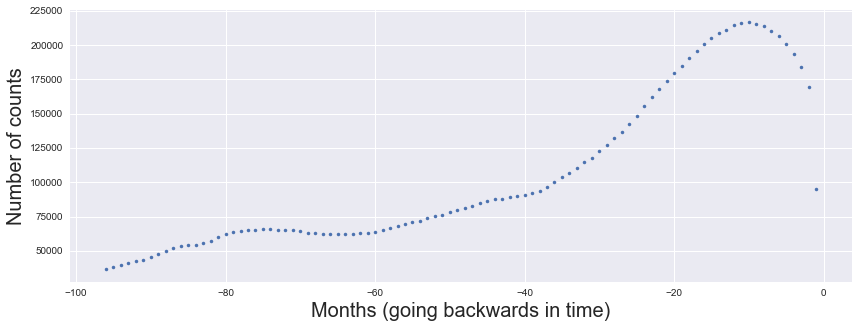

In [4]:
plt.figure(figsize=(14, 5))

temp = pcb.MONTHS_BALANCE.value_counts()
plt.plot(temp, ".")

plt.ylabel("Number of counts", fontsize=20)
_ = plt.xlabel("Months (going backwards in time)", fontsize=20)

<a id="pos_cnt"></a>

### [^](#toc) <u>CNT_INSTALMENT and CNT_INSTALMENT_FUTURE</u>

CNT_INSTALMENT - "Term of previous credit (can change over time)"

CNT_INSTALMENT_FUTURE - "Installments left to pay on the previous credit"

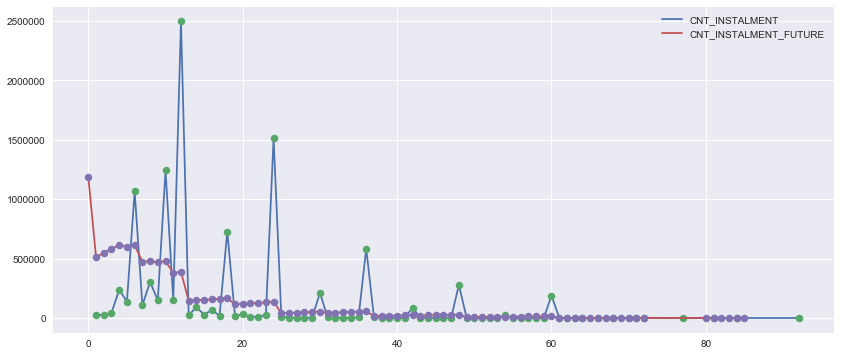

In [28]:
plt.figure(figsize=(14, 6))

for col in ("CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE"):
    temp = pcb[col].value_counts().sort_index()
    plt.plot(temp.index, temp.values, label=col)
    plt.plot(temp.index, temp.values, ".", markersize=15)
    
_ = plt.legend()

<a id="pos_name_contact_stat"></a>

### [^](#toc) <u>NAME_CONTRACT_STATUS</u>

"Contract status during the month"

Number of NaN entries: 0


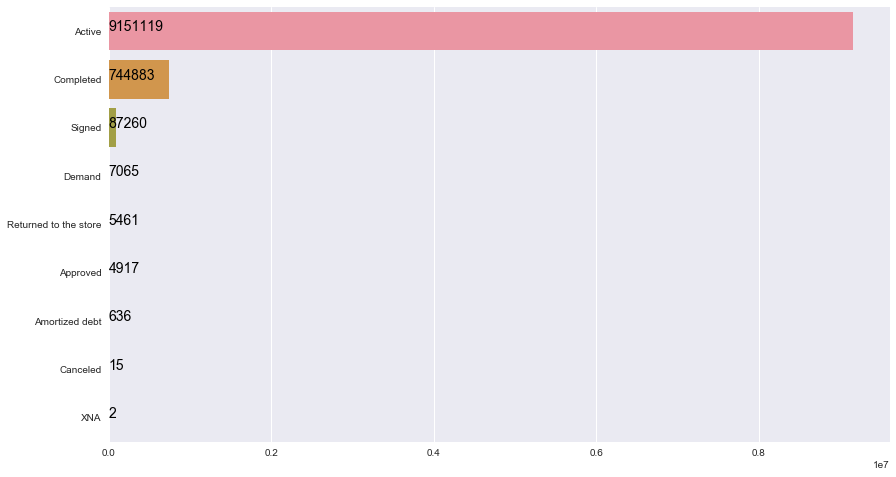

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
temp = pcb.NAME_CONTRACT_STATUS.value_counts()
print("Number of NaN entries: {}{}{}".format(color.BOLD, pcb.NAME_CONTRACT_STATUS.isnull().sum(), color.END))
pretty_bar(temp, ax)

<a id="pos_sk_dpd"></a>

### [^](#toc) <u>SK_DPD and SK_DPD_DEF</u>

SK_DPD - "DPD (days past due) during the month of previous credit"

SK_DPD_DEF - "DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit"

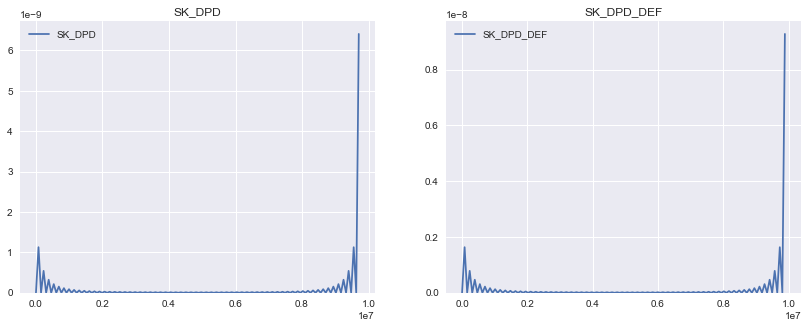

In [13]:
fig, axarr = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(pcb.SK_DPD.value_counts(), ax=axarr[0]).set(title="SK_DPD")
_ = sns.kdeplot(pcb.SK_DPD_DEF.value_counts(), ax=axarr[1]).set(title="SK_DPD_DEF")

<a name="install_payments"></a>

# [^](#toc) <u>installments_payments.csv</u>

(Open to see description of columns)

<div hidden>

,Table,Row,Description,Special

214,SK_ID_PREV ,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",hashed
215,SK_ID_CURR,ID of loan in our sample,hashed
216,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed,
217,NUM_INSTALMENT_NUMBER,On which installment we observe payment,
218,DAYS_INSTALMENT,When the installment of previous credit was supposed to be paid (relative to application date of current loan),time only relative to the application
219,DAYS_ENTRY_PAYMENT,When was the installments of previous credit paid actually (relative to application date of current loan),time only relative to the application
220,AMT_INSTALMENT,What was the prescribed installment amount of previous credit on this installment,
221,AMT_PAYMENT,What the client actually paid on previous credit on this installment,


</div>

In [3]:
install_pay = load("installments_payments.csv")
print("Shape of install_pay:",  install_pay.shape)

print("\n{}Columns of install_pay:{}".format(color.UNDERLINE, color.END))
print(" --- ".join(install_pay.columns.values))

Shape of install_pay: (13605401, 8)

Columns of install_pay:
SK_ID_PREV --- SK_ID_CURR --- NUM_INSTALMENT_VERSION --- NUM_INSTALMENT_NUMBER --- DAYS_INSTALMENT --- DAYS_ENTRY_PAYMENT --- AMT_INSTALMENT --- AMT_PAYMENT


<a id="install_nan"></a>

### [^](#toc) <u>Missing values</u>

In [4]:
total = install_pay.isnull().sum()
percent = total / len(install_pay)

pd.DataFrame({
    "Total Missing": list(total),
    "Percent Missing": list(percent)
}, index=total.index)

,Percent Missing,Total Missing
SK_ID_PREV,0.000000,0
SK_ID_CURR,0.000000,0
NUM_INSTALMENT_VERSION,0.000000,0
NUM_INSTALMENT_NUMBER,0.000000,0
DAYS_INSTALMENT,0.000000,0
DAYS_ENTRY_PAYMENT,0.000214,2905
AMT_INSTALMENT,0.000000,0
AMT_PAYMENT,0.000214,2905


<a id="install_nan_closer"></a>

### [^](#toc) <u>NaN values - closer look</u>

DAYS_ENTRY_PAYMENT and AMT_PAYMENT

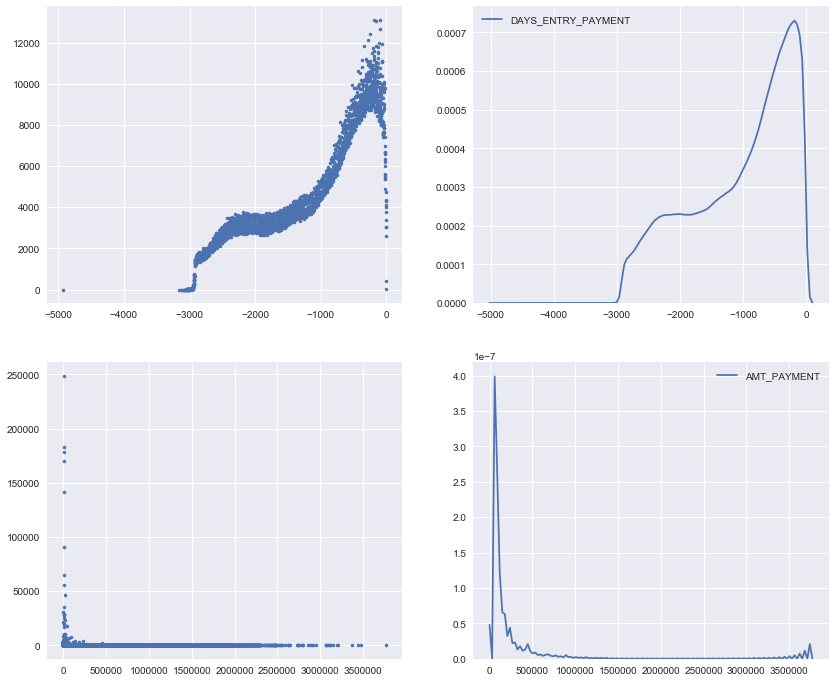

In [6]:
fig, axarr = plt.subplots(2, 2, figsize=(14, 12))

### DAYS_ENTRY_PAYMENT
temp = install_pay.DAYS_ENTRY_PAYMENT.value_counts()
axarr[0][0].plot(temp, ".")
axarr[1][0].set_title("DAYS_ENTRY_PAYMENT")

sns.kdeplot(install_pay.DAYS_ENTRY_PAYMENT, ax=axarr[0][1])

### AMT_PAYMENT
temp = install_pay.AMT_PAYMENT.value_counts()
axarr[1][0].plot(temp, ".")
axarr[1][0].set_title("AMT_PAYMENT")

_ = sns.kdeplot(install_pay.AMT_PAYMENT, ax=axarr[1][1])

<a id="install_remain"></a>

### [^](#toc) <u>Remaining columns</u>

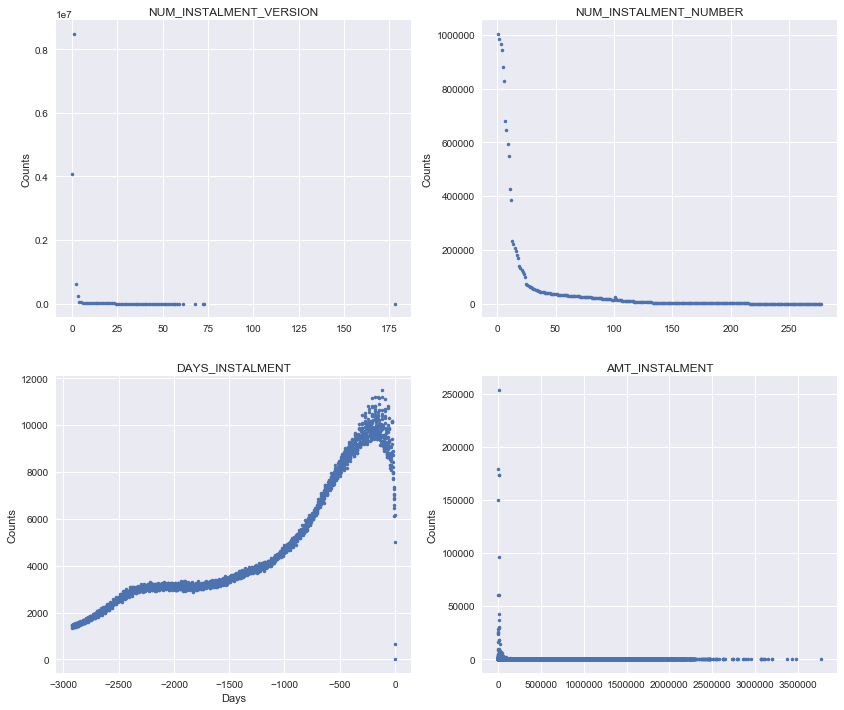

In [51]:
fig, axarr = plt.subplots(2, 2, figsize=(14, 12))

temp = install_pay.NUM_INSTALMENT_VERSION.value_counts()
axarr[0][0].plot(temp, ".")
axarr[0][0].set_title("NUM_INSTALMENT_VERSION")
axarr[0][0].set_ylabel("Counts")

temp = install_pay.NUM_INSTALMENT_NUMBER.value_counts()
axarr[0][1].plot(temp, ".")
axarr[0][1].set_title("NUM_INSTALMENT_NUMBER")
axarr[0][1].set_ylabel("Counts")

temp = install_pay.DAYS_INSTALMENT.value_counts()
axarr[1][0].plot(temp, ".")
axarr[1][0].set_title("DAYS_INSTALMENT")
axarr[1][0].set_xlabel("Days")
axarr[1][0].set_ylabel("Counts")

temp = install_pay.AMT_INSTALMENT.value_counts()
axarr[1][1].plot(temp, ".")
axarr[1][1].set_title("AMT_INSTALMENT")
_ = axarr[1][1].set_ylabel("Counts")

<a id="install_ver"></a>

### [^](#toc) NUM_INSTALMENT_VERSION

In [9]:
install_pay.NUM_INSTALMENT_VERSION.unique()

array([   1.,    0.,    2.,    4.,    3.,    5.,    7.,    8.,    6.,
         13.,    9.,   21.,   22.,   12.,   17.,   18.,   11.,   14.,
         34.,   33.,   19.,   16.,   15.,   10.,   26.,   27.,   20.,
         25.,   23.,   24.,   31.,   32.,   28.,   35.,   29.,   30.,
         43.,   39.,   40.,   36.,   41.,   42.,   37.,   38.,   68.,
         44.,   45.,   46.,  178.,   52.,   51.,   53.,   54.,   49.,
         50.,   58.,   57.,   55.,   56.,   48.,   47.,   72.,   59.,
         73.,   61.])

### AMT_INSTALMENT and AMT_PAYMENT

<strong>AMT_INSTALMENT</strong> - What was the prescribed installment amount of previous credit on this installment

<strong>AMT_PAYMENT</strong> - What the client actually paid on previous credit on this installment

In [58]:
install_pay["AMT_MISSING"] = install_pay["AMT_INSTALMENT"] - install_pay["AMT_PAYMENT"]
install_pay["AMT_MISSING"].describe()

count    1.360540e+07
mean    -1.836356e+02
std      1.912470e+04
min     -2.630909e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.424726e+06
Name: AMT_MISSING, dtype: float64

<a name="credit_card"></a>

# [^](#toc) <u>credit_card_balance.csv</u>

(Open to see description of columns)


<div hidden>

,Row,Description,Special

153,SK_ID_PREV ,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",hashed
154,SK_ID_CURR,ID of loan in our sample,hashed
155,MONTHS_BALANCE,Month of balance relative to application date (-1 means the freshest balance date),time only relative to the application

156,AMT_BALANCE,Balance during the month of previous credit,
157,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the previous credit,

158,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the previous credit,
168,CNT_DRAWINGS_ATM_CURRENT,Number of drawings at ATM during this month on the previous credit,

159,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previous credit,
169,CNT_DRAWINGS_CURRENT,Number of drawings during this month on the previous credit,

160,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of the previous credit,
170,CNT_DRAWINGS_OTHER_CURRENT,Number of other drawings during this month on the previous credit,

161,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the month of the previous credit,
171,CNT_DRAWINGS_POS_CURRENT,Number of drawings for goods during this month on the previous credit,

162,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the previous credit,
163,AMT_PAYMENT_CURRENT,How much did the client pay during the month on the previous credit,
164,AMT_PAYMENT_TOTAL_CURRENT,How much did the client pay during the month in total on the previous credit,
165,AMT_RECEIVABLE_PRINCIPAL,Amount receivable for principal on the previous credit,
166,AMT_RECIVABLE,Amount receivable on the previous credit,
167,AMT_TOTAL_RECEIVABLE,Total amount receivable on the previous credit,

172,CNT_INSTALMENT_MATURE_CUM,Number of paid installments on the previous credit,

173,NAME_CONTRACT_STATUS,"Contract status (active signed,...) on the previous credit",

174,SK_DPD,DPD (Days past due) during the month on the previous credit,
175,SK_DPD_DEF,DPD (Days past due) during the month with tolerance (debts with low loan amounts are ignored) of the previous credit,

</div>

In [22]:
credit_card = load("credit_card_balance.csv")
print("Shape of credit_card:",  credit_card.shape)

print("\n{}Columns of credit_card:{}".format(color.UNDERLINE, color.END))
print(" --- ".join(credit_card.columns.values))

Shape of credit_card: (3840312, 23)

Columns of credit_card:
SK_ID_PREV --- SK_ID_CURR --- MONTHS_BALANCE --- AMT_BALANCE --- AMT_CREDIT_LIMIT_ACTUAL --- AMT_DRAWINGS_ATM_CURRENT --- AMT_DRAWINGS_CURRENT --- AMT_DRAWINGS_OTHER_CURRENT --- AMT_DRAWINGS_POS_CURRENT --- AMT_INST_MIN_REGULARITY --- AMT_PAYMENT_CURRENT --- AMT_PAYMENT_TOTAL_CURRENT --- AMT_RECEIVABLE_PRINCIPAL --- AMT_RECIVABLE --- AMT_TOTAL_RECEIVABLE --- CNT_DRAWINGS_ATM_CURRENT --- CNT_DRAWINGS_CURRENT --- CNT_DRAWINGS_OTHER_CURRENT --- CNT_DRAWINGS_POS_CURRENT --- CNT_INSTALMENT_MATURE_CUM --- NAME_CONTRACT_STATUS --- SK_DPD --- SK_DPD_DEF


<a id="credit_nan"></a>

### [^](#toc) <u>Missing Values</u>

Nice, all the missing values are under 1%

In [23]:
total = credit_card.isnull().sum()
percent = total / len(credit_card)

temp = pd.DataFrame({
    "Total Missing": list(total),
    "Percent Missing": list(percent)
}, index=total.index)
temp[temp["Total Missing"] != 0]

,Percent Missing,Total Missing
AMT_DRAWINGS_ATM_CURRENT,0.195249,749816
AMT_DRAWINGS_OTHER_CURRENT,0.195249,749816
AMT_DRAWINGS_POS_CURRENT,0.195249,749816
AMT_INST_MIN_REGULARITY,0.079482,305236
AMT_PAYMENT_CURRENT,0.199981,767988
CNT_DRAWINGS_ATM_CURRENT,0.195249,749816
CNT_DRAWINGS_OTHER_CURRENT,0.195249,749816
CNT_DRAWINGS_POS_CURRENT,0.195249,749816
CNT_INSTALMENT_MATURE_CUM,0.079482,305236


<a id="credit_num_nan"></a>

### [^](#toc) <u>Numeric columns missing values</u>

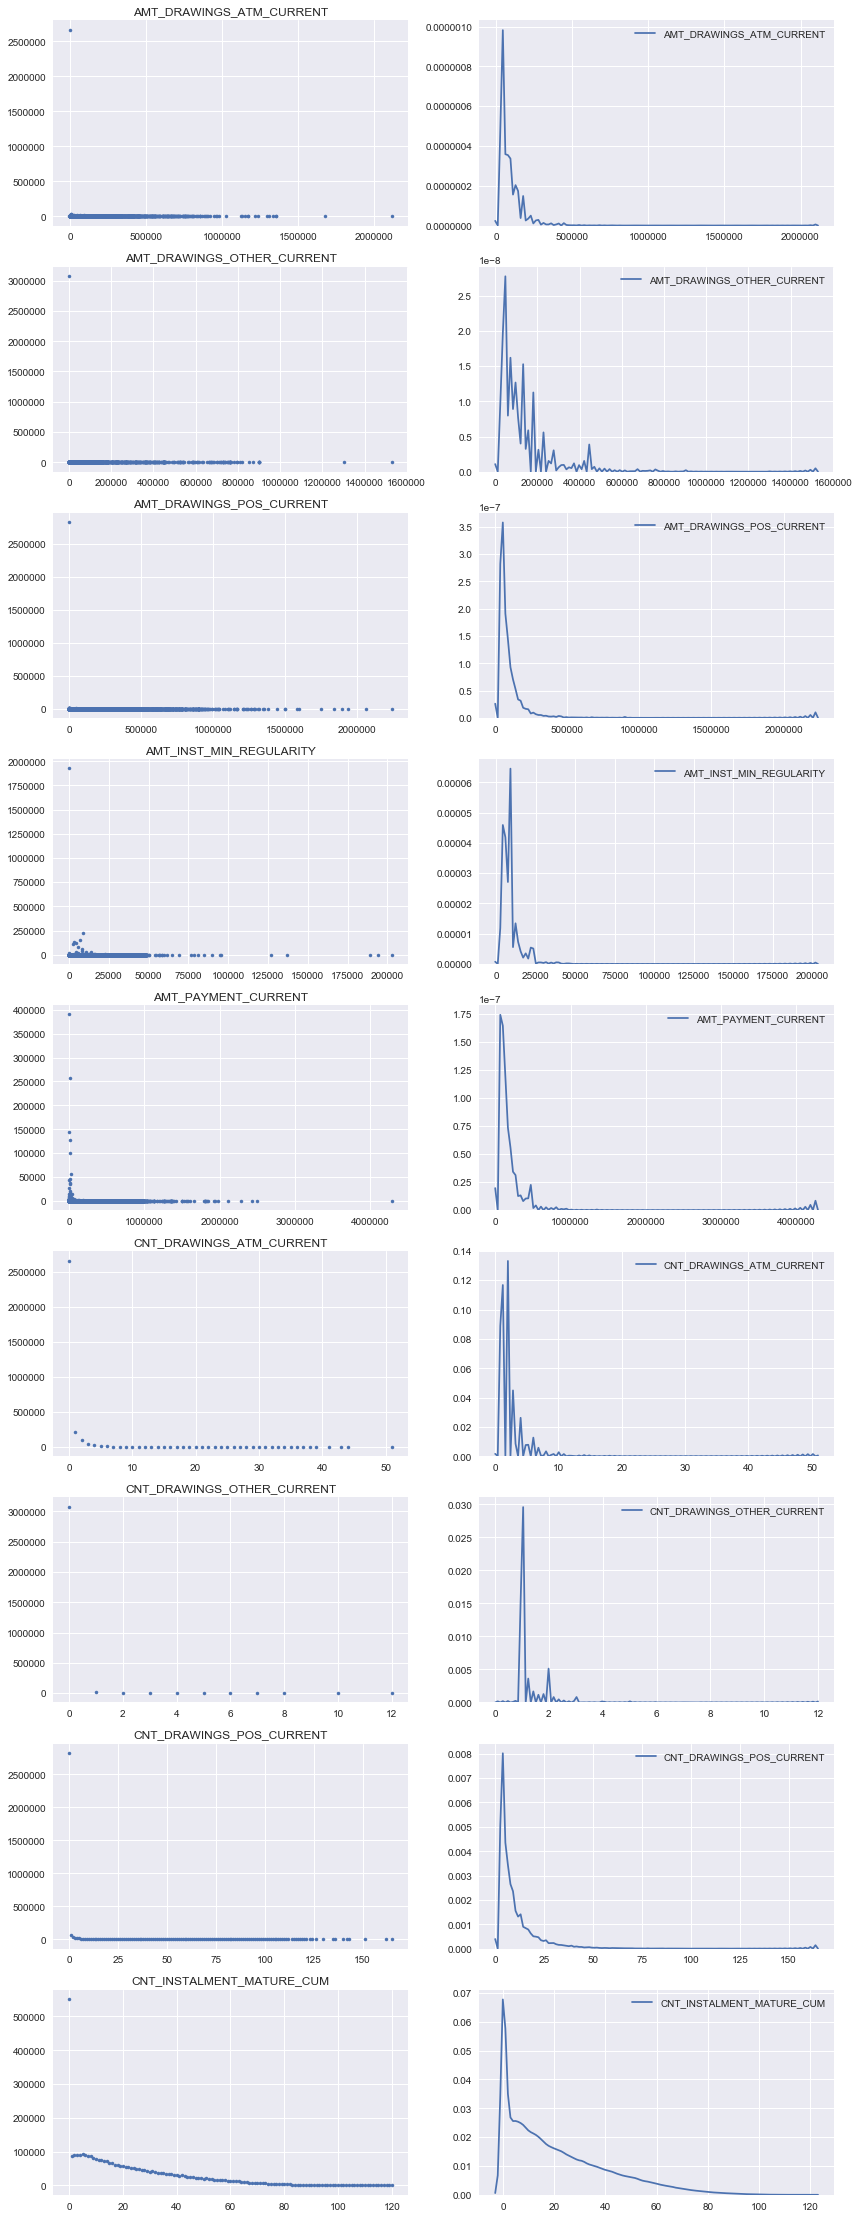

In [46]:
fig, axarr = plt.subplots(9, 2, figsize=(14, 40))

cols = [
        "AMT_DRAWINGS_ATM_CURRENT", "AMT_DRAWINGS_OTHER_CURRENT", "AMT_DRAWINGS_POS_CURRENT", 
        "AMT_INST_MIN_REGULARITY", "AMT_PAYMENT_CURRENT", "CNT_DRAWINGS_ATM_CURRENT", 
        "CNT_DRAWINGS_OTHER_CURRENT", "CNT_DRAWINGS_POS_CURRENT", "CNT_INSTALMENT_MATURE_CUM"
]

for i, col in enumerate(cols):
    temp = credit_card[col].value_counts()
    axarr[i][0].plot(temp, ".")
    axarr[i][0].set_title(col)
    sns.kdeplot(credit_card[col], ax=axarr[i][1])

<a id="credit_remain_num"></a>

### [^](#toc) <u>Remaing numeric columns</u>

AMT_CREDIT_LIMIT_ACTUAL --- AMT_DRAWINGS_CURRENT --- AMT_PAYMENT_TOTAL_CURRENT --- AMT_RECEIVABLE_PRINCIPAL --- AMT_RECIVABLE --- AMT_TOTAL_RECEIVABLE --- CNT_DRAWINGS_CURRENT
 
Treating separately MONTHS_BALANCE, AMT_BALANCE, SK_DPD, SK_DPD_DEF

A lot of columns appear to have a huge mode, I wonder how problematic this is?

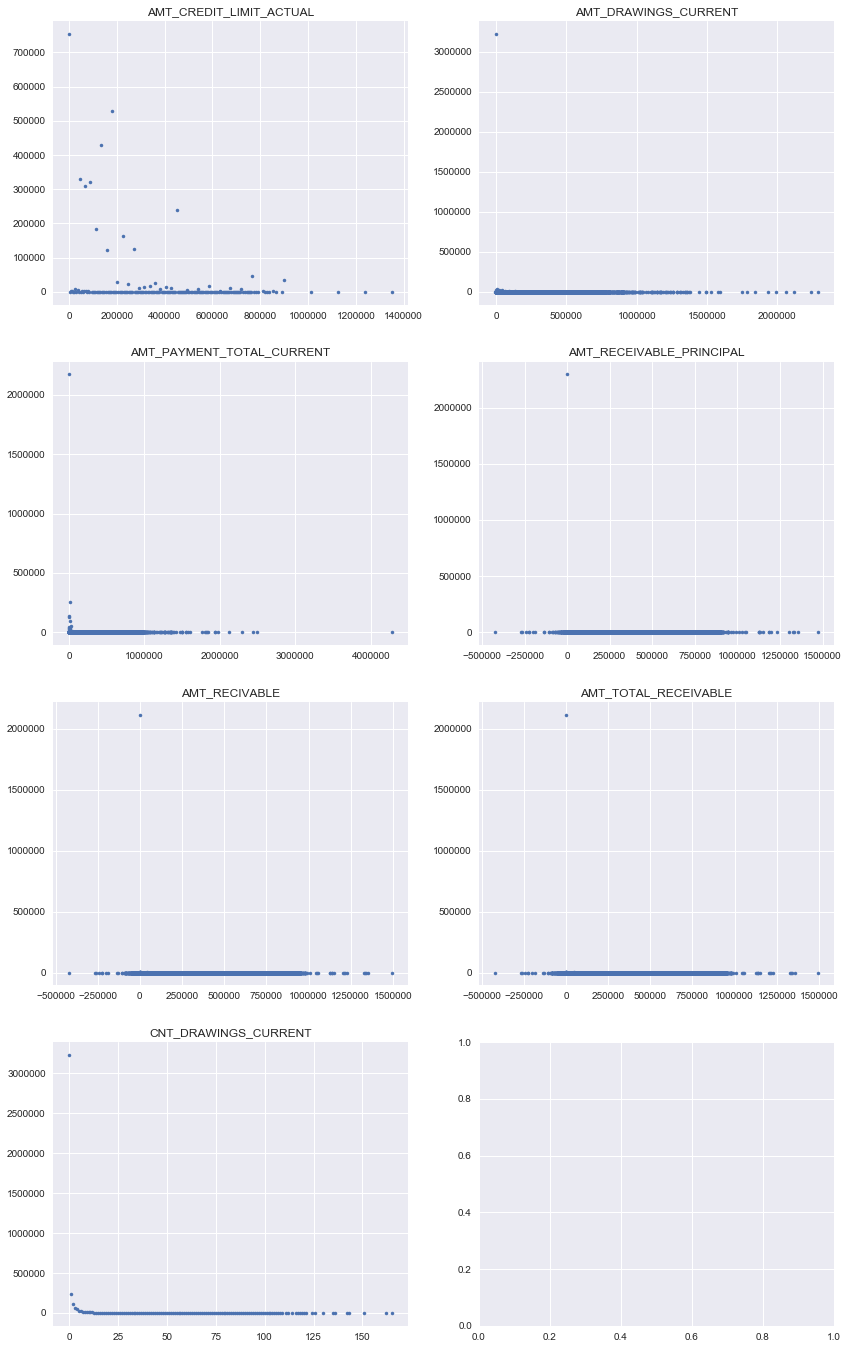

In [47]:
fig, axarr = plt.subplots(4, 2, figsize=(14, 24))

cols =["AMT_CREDIT_LIMIT_ACTUAL", "AMT_DRAWINGS_CURRENT", 
       "AMT_PAYMENT_TOTAL_CURRENT", "AMT_RECEIVABLE_PRINCIPAL", 
       "AMT_RECIVABLE", "AMT_TOTAL_RECEIVABLE",
       "CNT_DRAWINGS_CURRENT"]

for i, col in enumerate(cols):
    temp = credit_card[col].value_counts()
    axarr[i//2][i%2].plot(temp, ".")
    axarr[i//2][i%2].set_title(col)

### SK_DPD and SK_DPD_DEF

<strong>SK_DPD</strong> - Days past due during the month on the previous credit

<strong>SK_DPD_DEF</strong> - Days past due during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

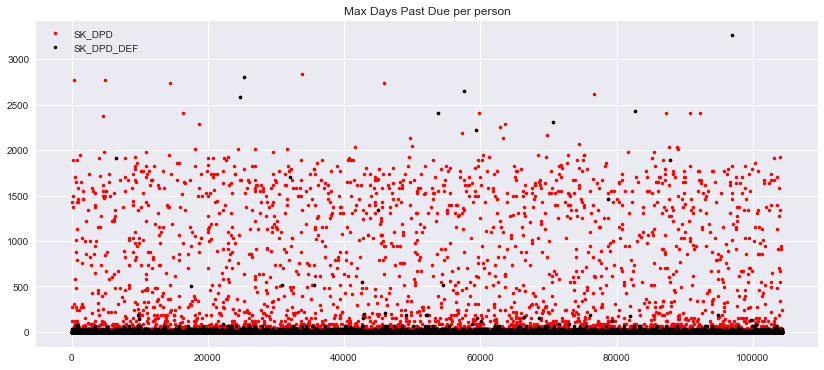

In [44]:
plt.figure(figsize=(14,6))

temp = credit_card.groupby("SK_ID_PREV").SK_DPD.max().reset_index()
plt.plot(temp.SK_DPD, ".", label="SK_DPD", color="r")

temp = credit_card.groupby("SK_ID_PREV").SK_DPD_DEF.max().reset_index()
plt.plot(temp.SK_DPD_DEF, ".", label="SK_DPD_DEF", color="k")

plt.legend()
_ = plt.title("Max Days Past Due per person")

### AMT_BALANCE

"Balance during the month of previous credit"

Belongs with MONTHS_BALANCE (not included yet)

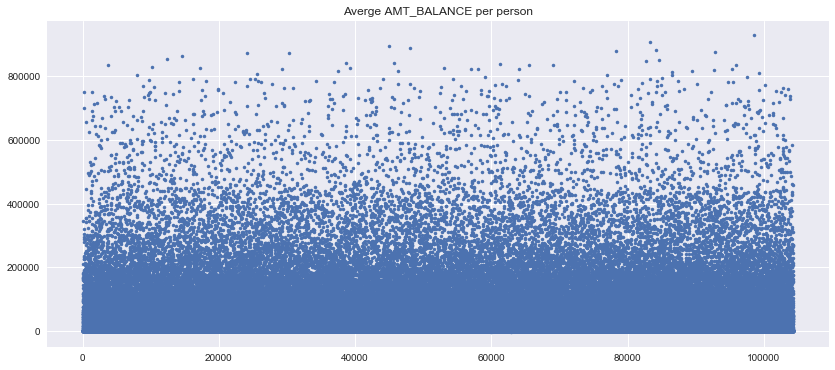

In [37]:
data = credit_card.groupby("SK_ID_PREV").AMT_BALANCE.mean().reset_index()

plt.figure(figsize=(14,6))
plt.plot(data.AMT_BALANCE, ".")
_ = plt.title("Averge AMT_BALANCE per person")

<a id="credit_cat_col"></a>

###  [^](#toc) <u>Categorical column(s)</u>

In [24]:
cat_cols = [col for col in credit_card if credit_card[col].dtype==object]
cat_cols

['NAME_CONTRACT_STATUS']

<a id="credit_name_contact_stat"></a>

### [^](#toc) <u>NAME_CONTRACT_STATUS</u>

In [30]:
credit_card.NAME_CONTRACT_STATUS.value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Name: NAME_CONTRACT_STATUS, dtype: int64